# Investigation of batch effects between two atlas studies

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [1]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2
import scanpy as sc

In [ ]:
#these need to be installed first
! sudo apt install tree
! sudo apt install jq
! pip install pronto

## 1.2 Download bulk dataset

Data used for the bulk RNA-seq expression is the [GTEx Consortium](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-5214/Results) experiment which sampled data from 53 human tissue samples from Expression Atlas. The entire database from Expression Atlas was accessed from a google cloud bucket which contains the data processed by the Expression Atlas. Below I create directories 'metadata', containing the experiments metadata to (JSON format), and 'aggregated data', containing two files for each experiment (TPM counts and FKPM counts).

In [25]:
! mkdir -p 'aggregated_data' 'metadata'
! gsutil -q -m rsync -r 'gs://ot-team/tskir/rel_38_2023-03-31/aggregated_data' 'aggregated_data'
! gsutil -q -m rsync -r 'gs://ot-team/tskir/rel_38_2023-03-31/metadata' 'metadata'

Below is a list of the experiments contained within the Expression Atlas data. Each experiment is listed as an individual directory.

In [2]:
!ls metadata

E-CURD-15      E-GEOD-43721  E-GEOD-94457  E-MTAB-3724	E-MTAB-5117
E-CURD-23      E-GEOD-43727  E-GEOD-95399  E-MTAB-3725	E-MTAB-513
E-CURD-25      E-GEOD-44366  E-GEOD-95678  E-MTAB-3726	E-MTAB-5200
E-CURD-26      E-GEOD-46817  E-GEOD-97960  E-MTAB-3727	E-MTAB-5214
E-CURD-27      E-GEOD-46858  E-GEOD-98097  E-MTAB-3819	E-MTAB-5423
E-CURD-30      E-GEOD-47948  E-GEOD-98379  E-MTAB-3826	E-MTAB-552
E-CURD-31      E-GEOD-49906  E-GEOD-98817  E-MTAB-3827	E-MTAB-5782
E-CURD-33      E-GEOD-50191  E-GEOD-99122  E-MTAB-3838	E-MTAB-5895
E-CURD-34      E-GEOD-50777  E-GEUV-1	   E-MTAB-3839	E-MTAB-5915
E-CURD-35      E-GEOD-51662  E-MTAB-10582  E-MTAB-3871	E-MTAB-5956
E-CURD-39      E-GEOD-52564  E-MTAB-10583  E-MTAB-3983	E-MTAB-599
E-CURD-47      E-GEOD-52806  E-MTAB-10847  E-MTAB-4021	E-MTAB-6422
E-ENAD-1       E-GEOD-53960  E-MTAB-11005  E-MTAB-4034	E-MTAB-6592
E-ENAD-11      E-GEOD-54272  E-MTAB-11442  E-MTAB-4045	E-MTAB-6769
E-ENAD-2       E-GEOD-55482  E-MTAB-11622  E-MTAB-4101	E-MTAB-6782


In [33]:
! tree 'metadata' | head -10

metadata
├── E-CURD-15
│   └── E-CURD-15.metadata.json
├── E-CURD-23
│   └── E-CURD-23.metadata.json
├── E-CURD-25
│   └── E-CURD-25.metadata.json
├── E-CURD-26
│   └── E-CURD-26.metadata.json
├── E-CURD-27


In [35]:
! tree 'aggregated_data' | head -19

aggregated_data
├── E-CURD-15
│   ├── E-CURD-15-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-15-expression-data-tpms.jsonl.bz2
├── E-CURD-23
│   ├── E-CURD-23-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-23-expression-data-tpms.jsonl.bz2
├── E-CURD-25
│   ├── E-CURD-25-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-25-expression-data-tpms.jsonl.bz2
├── E-CURD-26
│   ├── E-CURD-26-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-26-expression-data-tpms.jsonl.bz2
├── E-CURD-27
│   ├── E-CURD-27-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-27-expression-data-tpms.jsonl.bz2
├── E-CURD-30
│   ├── E-CURD-30-expression-data-fpkms.jsonl.bz2
│   └── E-CURD-30-expression-data-tpms.jsonl.bz2


## 1.3 Read in Tabular Sapiens expression data

In [2]:
#read in data from saved pickle
tabula_sapiens = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')
tabula_sapiens

ENSG00000227232  ENSG00000268903  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000241860  ENSG00000279457  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000228463  ENSG00000237094  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000225972  ENSG00000225630  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                              0.000000         0.101790   
               endothelial cell                    0.000000         0.000000   
               mast cell                           0.027070         1.606588   
               myeloid cell                        0.000000         0.000000   
               pancreatic acinar cell              0.000000         0.000000   
...                                                     ...              ...   
UBERON:0018707 plasma cell                         0.000000         0.000000   
               plasmacytoid dendritic cell         0.000000         0.000000   
               smooth muscle cell                  2.210239         0.000000   
               t cell                    

# 2. GTEx experiment
## 2.1 Access GTEx experiment

I want to use the GTEx dataset since it is large and internally consistent like the Tabula Sapiens Atlas meaning it does not require batch correction within it. Inside the Expression Atlas data, GTEx is found under the **E-MTAB-5214** experiment. But first, I need to define functions which can help extract the information needed. The cell below describes bash functions to extract the tissue names from the experiments and process the tissues into groups.

In [3]:
%%bash
cat <<'EOF' >bash_functions.sh
#!/bin/bash
extract_tissues () {
  # Not extracting cell types for now
  jq --raw-output '. as $experiment | .experimentalDesigns | .[] | $experiment.experimentId + "|" + .assayGroupId + "|" + .organismPart + "|" + .organismPartOntURI' <"$1" \
  | sort -u
}
process_tissues () {
  cut -d'|' -f3,4 \
  | sort \
  | uniq -c \
  | sort -k1,1rn \
  | sed -e 's/^ *//' -e 's/ /|/' \
  | tr '|' '\t'
}
export -f extract_tissues process_tissues
EOF

In [40]:
%%bash
. bash_functions.sh
extract_tissues metadata/E-MTAB-5214/E-MTAB-5214.metadata.json | process_tissues >'tissues_gtex.tsv'

## 2.2 List of tissues

In [5]:
#read in table of tissue assays
GTEx = pd.read_table('tissues_gtex.tsv', names=('count', 'organismPart', 'organismPartOntURI'))
with pd.option_context('display.max_rows', 500):
    display.display(GTEx)

,count,organismPart,organismPartOntURI
0,1,Brodmann (1909) area 24,http://purl.obolibrary.org/obo/UBERON_0006101
1,1,Brodmann (1909) area 9,http://purl.obolibrary.org/obo/UBERON_0013540
2,1,C1 segment of cervical spinal cord,http://purl.obolibrary.org/obo/UBERON_0006469
3,1,EBV-transformed lymphocyte,http://purl.obolibrary.org/obo/CL_0000542
4,1,adrenal gland,http://purl.obolibrary.org/obo/UBERON_0002369
5,1,amygdala,http://purl.obolibrary.org/obo/UBERON_0001876
6,1,aorta,http://purl.obolibrary.org/obo/UBERON_0000947
7,1,atrium auricular region,http://purl.obolibrary.org/obo/UBERON_0006618
8,1,blood,http://purl.obolibrary.org/obo/UBERON_0000178
9,1,breast,http://purl.obolibrary.org/obo/UBERON_0000310


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#change index to assay column
GTEx = GTEx.reset_index()
GTEx = GTEx.rename(columns = {'index': 'assay'})

#rename assays to reflect the ones in the expression data JSON file
for i in range(len(GTEx)):
    n = i + 1
    GTEx.assay[i] = f'g{n}'

#sort dataframe by assay_id string and reset the index so it is in the correct order, dropping the previous index
GTEx = GTEx.sort_values('assay').reset_index()
GTEx = GTEx.drop(columns = 'index')

GTEx

/tmp/ipykernel_1447/4229445611.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GTEx.assay[i] = f'g{n}'


,assay,count,organismPart,organismPartOntURI
0,g1,1,Brodmann (1909) area 24,http://purl.obolibrary.org/obo/UBERON_0006101
1,g10,1,breast,http://purl.obolibrary.org/obo/UBERON_0000310
2,g11,1,caudate nucleus,http://purl.obolibrary.org/obo/UBERON_0001873
3,g12,1,cerebellar hemisphere,http://purl.obolibrary.org/obo/UBERON_0002245
4,g13,1,cerebellum,http://purl.obolibrary.org/obo/UBERON_0002037
5,g14,1,cerebral cortex,http://purl.obolibrary.org/obo/UBERON_0000956
6,g15,1,coronary artery,http://purl.obolibrary.org/obo/UBERON_0001621
7,g16,1,cortex of kidney,http://purl.obolibrary.org/obo/UBERON_0001225
8,g17,1,ectocervix,http://purl.obolibrary.org/obo/UBERON_0012249
9,g18,1,endocervix,http://purl.obolibrary.org/obo/UBERON_0000458


There are 53 tissues with their corresponding UBERON IDs and there is only one aggregated assay per tissue.

## 2.3 Process expression data into pandas dataframe

In order to be able to 'compare' between bulk and single-cell RNA-seq data I will be using the TPM values for the expression data.

In [7]:
# Initialise Spark session
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '60g')
    .set('spark.executor.memory', '60g')
    .set('spark.driver.maxResultSize', '0')
    .set('spark.debug.maxToStringFields', '2000')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch', '500000')
)
spark = SparkSession.builder.config(conf=sparkConf).master('local[*]').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/28 09:09:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
#read in aggregated expression dataframe
GTEx_TPM = spark.read.json('aggregated_data/E-MTAB-5214/E-MTAB-5214-expression-data-tpms.jsonl.bz2')

In [9]:
#visualise data and schema
GTEx_TPM.printSchema()
GTEx_TPM.show()

root
 |-- expression: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- assayGroupId: string (nullable = true)
 |    |    |-- max: double (nullable = true)
 |    |    |-- min: double (nullable = true)
 |    |    |-- q1: double (nullable = true)
 |    |    |-- q2: double (nullable = true)
 |    |    |-- q3: double (nullable = true)
 |-- geneProductId: string (nullable = true)
 |-- unit: string (nullable = true)

+--------------------+---------------+----+
|          expression|  geneProductId|unit|
+--------------------+---------------+----+
|[{g1, 17.0, 0.0, ...|ENSG00000000003|tpms|
|[{g1, 0.6, 0.0, 0...|ENSG00000000005|tpms|
|[{g1, 87.0, 0.0, ...|ENSG00000000419|tpms|
|[{g1, 3.0, 0.0, 2...|ENSG00000000457|tpms|
|[{g1, 1.0, 0.0, 0...|ENSG00000000460|tpms|
|[{g1, 54.0, 0.0, ...|ENSG00000000938|tpms|
|[{g1, 30.0, 0.0, ...|ENSG00000000971|tpms|
|[{g1, 24.0, 0.0, ...|ENSG00000001036|tpms|
|[{g1, 23.0, 0.0, ...|ENSG00000001084|tpms|
|[{g1, 28.0, 0.0, ..

We only want to use the median expression (q2) values to compare them to the single-cell RNA-seq expressions.

In [10]:
#extract columns we are interested in
GTEx_counts = (
    GTEx_TPM
    .withColumn('expression_expl', explode('expression'))
    .select('geneProductId', 'expression_expl.assayGroupId', 'expression_expl.q2'))

GTEx_counts.show()

+---------------+------------+----+
|  geneProductId|assayGroupId|  q2|
+---------------+------------+----+
|ENSG00000000003|          g1| 6.0|
|ENSG00000000003|         g10|36.0|
|ENSG00000000003|         g11| 7.0|
|ENSG00000000003|         g12| 2.0|
|ENSG00000000003|         g13| 3.0|
|ENSG00000000003|         g14| 5.0|
|ENSG00000000003|         g15|11.0|
|ENSG00000000003|         g16|15.0|
|ENSG00000000003|         g17|39.0|
|ENSG00000000003|         g18|47.0|
|ENSG00000000003|         g19|10.0|
|ENSG00000000003|          g2| 5.0|
|ENSG00000000003|         g20|37.0|
|ENSG00000000003|         g21| 8.0|
|ENSG00000000003|         g22|30.0|
|ENSG00000000003|         g23|28.0|
|ENSG00000000003|         g24| 2.0|
|ENSG00000000003|         g25| 6.0|
|ENSG00000000003|         g26| 9.0|
|ENSG00000000003|         g27|24.0|
+---------------+------------+----+
only showing top 20 rows



In [11]:
#list of unique assay group IDs
assay_groups = sorted(
    [a.assayGroupId for a in GTEx_counts.select('assayGroupId').distinct().collect()])

In [12]:
#aggregate values into single expression map per gene
GTEx_counts = (
    GTEx_counts
    .groupby('geneProductId')
    .agg(
        f.map_from_entries(
            f.collect_list(
                f.struct('assayGroupId', 'q2')
            )
        ).alias('expression_map')))

GTEx_counts.show()

+---------------+--------------------+
|  geneProductId|      expression_map|
+---------------+--------------------+
|ENSG00000001561|{g1 -> 14.0, g10 ...|
|ENSG00000002822|{g1 -> 4.0, g10 -...|
|ENSG00000004142|{g1 -> 76.0, g10 ...|
|ENSG00000004766|{g1 -> 6.0, g10 -...|
|ENSG00000004809|{g1 -> 0.0, g10 -...|
|ENSG00000004948|{g1 -> 0.1, g10 -...|
|ENSG00000004975|{g1 -> 8.0, g10 -...|
|ENSG00000005073|{g1 -> 0.0, g10 -...|
|ENSG00000005175|{g1 -> 6.0, g10 -...|
|ENSG00000005187|{g1 -> 0.1, g10 -...|
|ENSG00000005486|{g1 -> 187.0, g10...|
|ENSG00000005884|{g1 -> 6.0, g10 -...|
|ENSG00000006015|{g1 -> 30.0, g10 ...|
|ENSG00000006071|{g1 -> 16.0, g10 ...|
|ENSG00000006194|{g10 -> 14.0, g11...|
|ENSG00000006283|{g1 -> 5.0, g10 -...|
|ENSG00000006638|{g1 -> 1.0, g10 -...|
|ENSG00000007062|{g1 -> 2.0, g10 -...|
|ENSG00000007216|{g1 -> 0.0, g10 -...|
|ENSG00000007264|{g1 -> 31.0, g10 ...|
+---------------+--------------------+
only showing top 20 rows



In [13]:
#convert single-mapped expression values into different columns
expression_cols = [f.col('expression_map').getItem(x).alias(str(x)) 
              for x in assay_groups]

#extract dataframe with assay as columns, genes as rows and values as TPMs
GTEx_expression = GTEx_counts.select('geneProductId', *expression_cols).toPandas()
GTEx_expression.set_index('geneProductId', inplace = True)

23/09/28 09:10:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [16]:
GTEx_expression

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,14.0,19.0,12.0,17.0,16.0,13.0,39.0,10.0,6.0,13.0,...,4.0,10.0,14.0,13.0,6.0,5.0,11.0,34.0,12.0,2.0
ENSG00000002822,4.0,8.0,5.0,8.0,7.0,6.0,6.0,4.0,11.0,10.0,...,9.0,4.0,5.0,7.0,10.0,9.0,3.0,7.0,4.0,6.0
ENSG00000004142,76.0,110.0,55.0,102.0,107.0,96.0,118.0,134.0,114.0,114.0,...,172.0,227.0,94.0,102.0,117.0,109.0,51.0,118.0,89.0,36.0
ENSG00000004766,6.0,8.0,4.0,15.0,14.0,8.0,8.0,4.0,9.0,9.0,...,9.0,7.0,7.0,7.0,10.0,9.0,3.0,8.0,3.0,1.0
ENSG00000004809,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,...,0.0,0.1,0.0,0.1,0.6,0.0,0.0,0.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000281906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000281909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.4 Filter out genes with zero expression across all assays

In [14]:
#use filter to eliminate genes that have zero expression across all tissue assays
non_zero = ~np.all(GTEx_expression == 0, axis = 1)
GTEx_expression = GTEx_expression[non_zero]

GTEx_expression

,g1,g10,g11,g12,g13,g14,g15,g16,g17,g18,...,g49,g5,g50,g51,g52,g53,g6,g7,g8,g9
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,14.0,19.0,12.0,17.0,16.0,13.0,39.0,10.0,6.0,13.0,...,4.0,10.0,14.0,13.0,6.0,5.0,11.0,34.0,12.0,2.0
ENSG00000002822,4.0,8.0,5.0,8.0,7.0,6.0,6.0,4.0,11.0,10.0,...,9.0,4.0,5.0,7.0,10.0,9.0,3.0,7.0,4.0,6.0
ENSG00000004142,76.0,110.0,55.0,102.0,107.0,96.0,118.0,134.0,114.0,114.0,...,172.0,227.0,94.0,102.0,117.0,109.0,51.0,118.0,89.0,36.0
ENSG00000004766,6.0,8.0,4.0,15.0,14.0,8.0,8.0,4.0,9.0,9.0,...,9.0,7.0,7.0,7.0,10.0,9.0,3.0,8.0,3.0,1.0
ENSG00000004809,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,...,0.0,0.1,0.0,0.1,0.6,0.0,0.0,0.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281676,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,2.0,...,1.0,0.8,1.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0
ENSG00000281741,0.6,0.5,0.4,0.6,0.6,0.6,0.6,0.4,0.7,0.6,...,0.3,0.4,0.3,0.6,0.3,0.4,0.4,0.7,0.1,0.8
ENSG00000281809,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.2,0.0,1.0,0.5,0.0,0.0,0.1,0.0,0.0,0.0


There are 46,711 genes across 53 tissue assays for the GTEx bulk data compared with 769 cell types for 24,166 genes across Tabula Sapiens after taking the median expression across the cell types in the same tissue and filtering out the genes that have zero expression across all cell types and tissues.

## 2.5 Set tissue name as column index

In [33]:
%%bash
. bash_functions.sh
extract_tissues metadata/E-MTAB-5214/E-MTAB-5214.metadata.json | tr '|' '\t' | cut -f2,3 > gtex_map.tsv

In [15]:
#create a dictionary for the tissue names from the gtex_map file and rename the columns in GTEx tissue TPM
GTEx_col_map = dict([line.split('\t') for line in open('gtex_map.tsv').read().splitlines()])
GTEx_tissue_TPM = (GTEx_expression
                   .rename(columns = GTEx_col_map))

GTEx_tissue_TPM

,Brodmann (1909) area 24,breast,caudate nucleus,cerebellar hemisphere,cerebellum,cerebral cortex,coronary artery,cortex of kidney,ectocervix,endocervix,...,transformed skin fibroblast,adrenal gland,transverse colon,urinary bladder,uterus,vagina,amygdala,aorta,atrium auricular region,blood
geneProductId,,,,,,,,,,,,,,,,,,,,,
ENSG00000001561,14.0,19.0,12.0,17.0,16.0,13.0,39.0,10.0,6.0,13.0,...,4.0,10.0,14.0,13.0,6.0,5.0,11.0,34.0,12.0,2.0
ENSG00000002822,4.0,8.0,5.0,8.0,7.0,6.0,6.0,4.0,11.0,10.0,...,9.0,4.0,5.0,7.0,10.0,9.0,3.0,7.0,4.0,6.0
ENSG00000004142,76.0,110.0,55.0,102.0,107.0,96.0,118.0,134.0,114.0,114.0,...,172.0,227.0,94.0,102.0,117.0,109.0,51.0,118.0,89.0,36.0
ENSG00000004766,6.0,8.0,4.0,15.0,14.0,8.0,8.0,4.0,9.0,9.0,...,9.0,7.0,7.0,7.0,10.0,9.0,3.0,8.0,3.0,1.0
ENSG00000004809,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,...,0.0,0.1,0.0,0.1,0.6,0.0,0.0,0.1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281676,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,2.0,...,1.0,0.8,1.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0
ENSG00000281741,0.6,0.5,0.4,0.6,0.6,0.6,0.6,0.4,0.7,0.6,...,0.3,0.4,0.3,0.6,0.3,0.4,0.4,0.7,0.1,0.8
ENSG00000281809,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.2,0.0,1.0,0.5,0.0,0.0,0.1,0.0,0.0,0.0


In [16]:
#transpose matrix so it resembles the Tabula Sapiens one
transposed_GTEx_tissue_TPM = GTEx_tissue_TPM.T

transposed_GTEx_tissue_TPM

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
Brodmann (1909) area 24,14.0,4.0,76.0,6.0,0.0,0.1,8.0,0.0,6.0,0.1,...,0.4,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
breast,19.0,8.0,110.0,8.0,0.1,0.1,24.0,0.7,11.0,2.0,...,1.0,0.0,0.0,2.0,0.9,1.0,0.5,0.0,0.0,2.0
caudate nucleus,12.0,5.0,55.0,4.0,0.0,0.0,8.0,0.0,5.0,0.1,...,0.4,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0
cerebellar hemisphere,17.0,8.0,102.0,15.0,0.0,0.0,31.0,0.0,16.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
cerebellum,16.0,7.0,107.0,14.0,0.0,0.0,37.0,0.0,14.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
cerebral cortex,13.0,6.0,96.0,8.0,0.0,0.0,15.0,0.0,6.0,0.1,...,0.5,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
coronary artery,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
cortex of kidney,10.0,4.0,134.0,4.0,0.1,0.9,13.0,3.0,5.0,7.0,...,0.5,0.0,0.0,3.0,0.1,0.0,0.4,0.0,0.0,2.0
ectocervix,6.0,11.0,114.0,9.0,0.0,0.0,50.0,57.0,15.0,15.0,...,1.0,0.0,0.0,3.0,0.0,0.7,0.7,0.0,0.0,3.0
endocervix,13.0,10.0,114.0,9.0,0.1,0.1,50.0,102.0,16.0,10.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.6,0.0,0.0,3.0


In [14]:
#save dataframe as compressed pickle
transposed_GTEx_tissue_TPM.to_pickle('median_GTEx_tissue_id_TPM.pkl', compression = 'gzip')

# 3. Comparison between Tabula Sapiens single-cell and GTEx bulk
## 3.1 Convert tissue names to UBERON IDs for comparison

I'm interested in the tissues which are shared across both datasets so for accurate comparison across tissues I shall use the UBERON IDs.

In [17]:
#create list of uberon ids from the GTEx dataframe which matches the indexing of the dataframe columns
uberonid = []
for i in range(len(GTEx.organismPartOntURI)):
    uberon_num = GTEx.organismPartOntURI[i][-14:].replace('_', ':')
    uberonid.append(uberon_num)

In [18]:
#set the dataframe column axis as the uberon ids and transpose so matches Tabula Sapiens format
uberon_id_GTEx_expression = GTEx_expression.set_axis(uberonid, axis = 1)
uberon_id_GTEx_expression = uberon_id_GTEx_expression.T
uberon_id_GTEx_expression

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
UBERON:0006101,14.0,4.0,76.0,6.0,0.0,0.1,8.0,0.0,6.0,0.1,...,0.4,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0000310,19.0,8.0,110.0,8.0,0.1,0.1,24.0,0.7,11.0,2.0,...,1.0,0.0,0.0,2.0,0.9,1.0,0.5,0.0,0.0,2.0
UBERON:0001873,12.0,5.0,55.0,4.0,0.0,0.0,8.0,0.0,5.0,0.1,...,0.4,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0
UBERON:0002245,17.0,8.0,102.0,15.0,0.0,0.0,31.0,0.0,16.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0002037,16.0,7.0,107.0,14.0,0.0,0.0,37.0,0.0,14.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0000956,13.0,6.0,96.0,8.0,0.0,0.0,15.0,0.0,6.0,0.1,...,0.5,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0001621,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
UBERON:0001225,10.0,4.0,134.0,4.0,0.1,0.9,13.0,3.0,5.0,7.0,...,0.5,0.0,0.0,3.0,0.1,0.0,0.4,0.0,0.0,2.0
UBERON:0012249,6.0,11.0,114.0,9.0,0.0,0.0,50.0,57.0,15.0,15.0,...,1.0,0.0,0.0,3.0,0.0,0.7,0.7,0.0,0.0,3.0
UBERON:0000458,13.0,10.0,114.0,9.0,0.1,0.1,50.0,102.0,16.0,10.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.6,0.0,0.0,3.0


## 3.2 Drop cell ontology (CL) rows

The rows with cell ontology terms, beginning with `CL`, will be dropped since these are not present in the Tabula Sapiens dataset.

In [19]:
#drop rows with indices that contained the CL prefix
uberon_id_GTEx_expression = uberon_id_GTEx_expression.drop(['obo/CL:0000057', 'obo/CL:0000542'])
uberon_id_GTEx_expression

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
UBERON:0006101,14.0,4.0,76.0,6.0,0.0,0.1,8.0,0.0,6.0,0.1,...,0.4,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0000310,19.0,8.0,110.0,8.0,0.1,0.1,24.0,0.7,11.0,2.0,...,1.0,0.0,0.0,2.0,0.9,1.0,0.5,0.0,0.0,2.0
UBERON:0001873,12.0,5.0,55.0,4.0,0.0,0.0,8.0,0.0,5.0,0.1,...,0.4,0.0,0.0,1.0,0.0,0.0,0.4,0.0,0.0,1.0
UBERON:0002245,17.0,8.0,102.0,15.0,0.0,0.0,31.0,0.0,16.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0002037,16.0,7.0,107.0,14.0,0.0,0.0,37.0,0.0,14.0,0.2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.6,0.0,0.0,3.0
UBERON:0000956,13.0,6.0,96.0,8.0,0.0,0.0,15.0,0.0,6.0,0.1,...,0.5,0.0,0.0,2.0,0.0,0.0,0.6,0.1,0.0,1.0
UBERON:0001621,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
UBERON:0001225,10.0,4.0,134.0,4.0,0.1,0.9,13.0,3.0,5.0,7.0,...,0.5,0.0,0.0,3.0,0.1,0.0,0.4,0.0,0.0,2.0
UBERON:0012249,6.0,11.0,114.0,9.0,0.0,0.0,50.0,57.0,15.0,15.0,...,1.0,0.0,0.0,3.0,0.0,0.7,0.7,0.0,0.0,3.0
UBERON:0000458,13.0,10.0,114.0,9.0,0.1,0.1,50.0,102.0,16.0,10.0,...,1.0,0.0,0.0,4.0,0.0,2.0,0.6,0.0,0.0,3.0


In [23]:
uberon_id_GTEx_expression.to_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

## 3.3 Identify UBERON IDs conserved across both datasets

In [ ]:
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

In [20]:
#GTEx tissue UBERON IDs
GTEX_uberon_ids = uberon_id_GTEx_expression.index

In [21]:
#UBERON IDs from Tabula Sapiens dataframe
###reset index to eliminate multi-index so can access uberon_id
##access list of unique UBERON IDs as they are repeated
tabula_uberon_ids = tabula_sapiens.reset_index().uberon_id.unique()

In [22]:
#find which UBERON IDs are shared across both datasets
shared_uberon_ids = set(GTEX_uberon_ids) & set(tabula_uberon_ids)
shared_uberon_ids

{'UBERON:0000178',
 'UBERON:0000947',
 'UBERON:0000995',
 'UBERON:0001621',
 'UBERON:0002048',
 'UBERON:0002106',
 'UBERON:0002107',
 'UBERON:0002190',
 'UBERON:0002367'}

Here, I see that there are nine tissues across GTEx and Tabula Sapiens that share the exact same UBERON ID so I will use these to compare the two datasets. These UBERON IDs correspond to blood, aorta, uterus, coronary artery, lung, spleen, liver, adipose tissue and prostate gland.

## 3.4 Reformat datasets to retain only shared UBERON ID data

In [23]:
#filter GTEx by shared UBERON ID rows
shared_uberon_id_GTEx_expression = uberon_id_GTEx_expression.filter(shared_uberon_ids, axis = 0)
shared_uberon_id_GTEx_expression

geneProductId,ENSG00000001561,ENSG00000002822,ENSG00000004142,ENSG00000004766,ENSG00000004809,ENSG00000004948,ENSG00000004975,ENSG00000005073,ENSG00000005175,ENSG00000005187,...,ENSG00000281548,ENSG00000281549,ENSG00000281566,ENSG00000281571,ENSG00000281655,ENSG00000281676,ENSG00000281741,ENSG00000281809,ENSG00000281909,ENSG00000281912
UBERON:0001621,39.0,6.0,118.0,8.0,0.1,0.1,22.0,0.0,11.0,3.0,...,0.8,0.0,0.0,3.0,0.0,0.0,0.6,0.0,0.0,1.0
UBERON:0002107,5.0,3.0,159.0,2.0,0.0,0.0,6.0,0.0,4.0,8.0,...,0.3,0.0,0.0,2.0,3.0,0.0,0.3,0.0,0.0,1.0
UBERON:0002048,29.0,8.0,100.0,8.0,0.4,0.1,23.0,0.0,10.0,3.0,...,1.0,0.0,0.0,3.0,0.0,2.0,0.5,1.0,0.0,1.0
UBERON:0002367,12.0,8.0,117.0,7.0,0.1,0.0,37.0,24.0,11.0,6.0,...,1.0,0.0,0.0,3.0,0.2,2.0,0.7,0.5,0.1,3.0
UBERON:0002106,15.0,13.0,104.0,9.0,0.5,0.0,23.0,0.0,13.0,1.0,...,1.0,0.0,0.0,7.0,0.0,3.0,1.0,0.0,0.0,2.0
UBERON:0002190,23.0,8.0,113.0,8.0,0.2,0.1,22.0,6.0,11.0,0.5,...,1.0,0.0,0.0,2.0,0.3,2.0,0.3,0.0,0.0,1.0
UBERON:0000995,6.0,10.0,117.0,10.0,0.6,0.0,52.0,149.0,16.0,34.0,...,1.0,0.0,0.0,2.0,0.1,2.0,0.3,0.0,0.0,2.0
UBERON:0000947,34.0,7.0,118.0,8.0,0.1,0.1,26.0,0.1,12.0,0.9,...,0.8,0.0,0.0,3.0,0.0,0.0,0.7,0.0,0.0,1.0
UBERON:0000178,2.0,6.0,36.0,1.0,1.0,0.0,5.0,0.0,3.0,0.5,...,0.5,0.0,0.0,3.0,0.0,2.0,0.8,0.0,0.0,0.2


In [24]:
#filter Tabula Sapiens by shared UBERON IDs across the multi-index using level = 0 to specify the uberon_id index
shared_uberon_id_tabula_sapiens = tabula_sapiens[tabula_sapiens.index.isin(shared_uberon_ids, level = 0)]
shared_uberon_id_tabula_sapiens

ENSG00000227232  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000268903  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000241860  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000279457  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                            0.0   
               cd141-positive myeloid dendritic cell               0.0   
               cd24 neutrophil                                     0.0   
               cd4-positive, alpha-beta memory t cell              0.0   
               cd4-positive, alpha-beta t cell                     0.0   
...                                                                ...   
UBERON:0002367 nkt cell                                            0.0   
               smooth muscle cell                                  0.0   
               sperm                                               0.0   
               stromal cell                                        0.0   
               t cell                                              0.0   

                                                       ENSG00000228463  \
uberon_id      cell_type                                                 
UBERON:0000178 basophil                                

In [29]:
shared_uberon_id_tabula_sapiens.to_pickle('shared_uberon_id_tabula_sapiens.pkl', compression = 'gzip')

## 3.5 Merge shared UBERON ID dataframes

In [25]:
#eliminate cell_types from Tabula Sapiens to allow merging of dataframes on UBERON ID
ts = shared_uberon_id_tabula_sapiens.reset_index().drop(columns = 'cell_type').set_index('uberon_id')
ts

,ENSG00000227232,ENSG00000268903,ENSG00000241860,ENSG00000279457,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
uberon_id,,,,,,,,,,,,,,,,,,,,,
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,23.122616,0.0,0.0,0.0,10.617577,0.689311,0.0,30.212013,0.0,0.761426
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,25.668995,0.0,0.0,0.0,13.845222,0.899192,0.0,36.836357,0.0,0.000000
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,6.858539,0.00000,...,24.904129,0.0,0.0,0.0,6.660645,0.000000,0.0,36.145561,0.0,15.926369
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,24.851427,0.0,0.0,0.0,11.422455,1.352069,0.0,40.610580,0.0,0.000000
UBERON:0000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,23.102156,0.0,0.0,0.0,7.663464,1.667645,0.0,40.170292,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UBERON:0002367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,50.350475,0.0,0.0,0.0,16.439199,0.000000,0.0,71.210800,0.0,0.000000
UBERON:0002367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,58.919147,0.0,0.0,0.0,15.376302,0.000000,0.0,79.589516,0.0,0.000000
UBERON:0002367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,15.944453,0.0,0.0,0.0,5.544242,0.000000,0.0,19.229773,0.0,0.000000


In [26]:
#concatenate dataframes and set levels as the dataset origin
merged_shared_uberon_id_datasets = pd.concat([shared_uberon_id_GTEx_expression, ts],
                                            keys = ['GTEx', 'Tabula_Sapiens'])
merged_shared_uberon_id_datasets

ENSG00000001561  ENSG00000002822  \
GTEx           UBERON:0001621        39.000000              6.0   
               UBERON:0002107         5.000000              3.0   
               UBERON:0002048        29.000000              8.0   
               UBERON:0002367        12.000000              8.0   
               UBERON:0002106        15.000000             13.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367         0.000000              0.0   
               UBERON:0002367         0.000000              0.0   
               UBERON:0002367         6.500235              0.0   
               UBERON:0002367         0.000000              0.0   
               UBERON:0002367         0.000000              0.0   

                               ENSG00000004142  ENSG00000004766  \
GTEx           UBERON:0001621            118.0              8.0   
               UBERON:0002107            159.0              2.0   
               UBERON:0002048            100.0              8.0   
               UBERON:0002367            117.0              7.0   
               UBERON:0002106            104.0              9.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   

                               ENSG00000004809  ENSG00000004948  \
GTEx           UBERON:0001621              0.1              0.1   
               UBERON:0002107              0.0              0.0   
               UBERON:0002048              0.4              0.1   
               UBERON:0002367              0.1              0.0   
               UBERON:0002106              0.5              0.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   
               UBERON:0002367              0.0              NaN   

                               ENSG00000004975  ENSG00000005073  \
GTEx           UBERON:0001621             22.0              0.0   
               UBERON:0002107              6.0              0.0   
               UBERON:0002048             23.0              0.0   
               UBERON:0002367             37.0             24.0   
               UBERON:0002106             23.0              0.0   
...                                        ...              ...   
Tabula_Sapiens UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   
               UBERON:0002367              0.0              0.0   

                               ENSG00000005175  ENSG00000005187  ...  \
GTEx           UBERON:0001621             11.0              3.0  ...   
               UBERON:0002107              4.0              8.0  ...   
               UBERON:0002048             10.0              3.0  ...   
               UBERON:0002367             11.0              6.0  ...   
               UBERON:0002106             13.0              1.0  ...   
...                                        ...              ...  ...   
Tabula_Sapiens UBERON:0002367              0.0              0.0  ...   
               UBERON:0002367              0.0              0.0  ...   
               UBERON:0002367              0.0              0.0  ...   
               UBERON:0002367              0.0              0.0  ...   
               UBER

In [27]:
merged_shared_uberon_id_datasets.to_pickle('GTEx_tabula_uberonid_datasets.pkl', compression = 'gzip')

## 3.6 Plot GTEx vs Tabula Sapiens expresssion data

In [3]:
merged_shared_uberon_id_datasets = pd.read_pickle('GTEx_tabula_uberonid_datasets.pkl', compression = 'gzip')

I want to observe the correlation between the median expression data for each tissue in GTEx vs in Tabula Sapiens so we will use plots for each UBERON ID of the GTEx expression vs the Tabula Sapiens expression for each gene.

### 3.6.1 UBERON:0000178

In [27]:
def uberon_subset(uberonid, df):
    
    return df[df.index.isin([uberonid], level = 1)]
    
def plot_gtex_tabula(uberon_df):
    
    #empty list for scatter data points
    scatter_data = []

    #iterate over genes
    for gene in uberon_df.columns:
    
        #select data for current gene
        gene_data = uberon_df[gene]
    
        #extract GTEx and Tabula Sapiens data
        gtex_data = gene_data.loc['GTEx'].dropna().values
        tabula_data = gene_data.loc['Tabula_Sapiens'].dropna().values
    
        #making sure the array is not empty
        if (gtex_data.size > 0) & (tabula_data.size > 0):
        
            #append data to scatterplot
            scatter_data.append((gene, gtex_data.max(), tabula_data.max()))
        
    #create dataframe for scatterplot
    scatter_df = pd.DataFrame(scatter_data, columns = ['Gene', 'GTEx', 'Tabula_Sapiens'])

    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')
    plt.xlabel('GTEx Expression')
    plt.ylabel('Tabula Sapiens Expression')
    
    return plt.show()

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


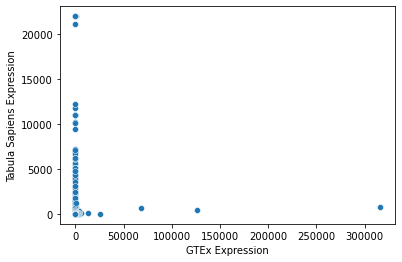

In [133]:
#subset uberonid out of the merged dataframe
uberon_0000178 = uberon_subset('UBERON:0000178', merged_shared_uberon_id_datasets)

#plot the expressions of each gene for GTEx and Tabula Sapiens (maximum median expression)
plot_gtex_tabula(uberon_0000178)

### 3.6.2 UBERON:0000947

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


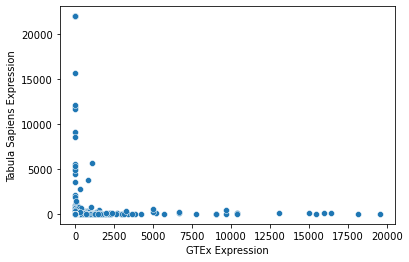

In [135]:
uberon_0000947 = uberon_subset('UBERON:0000947', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0000947)

### 3.6.3 UBERON:0000995

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


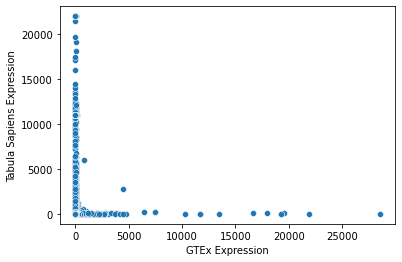

In [136]:
uberon_0000995 = uberon_subset('UBERON:0000995', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0000995)

### 3.6.4 UBERON:0001621

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


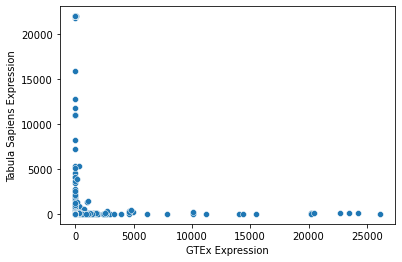

In [134]:
uberon_0001621 = uberon_subset('UBERON:0001621', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0001621)

Since there are multiple cell types for the Tabula Sapiens UBERONID resulting in a higher number of values than GTEx, I will use the maximum of these median values to allow a one-to-one comparison.

### 3.6.5 UBERON:0002048

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


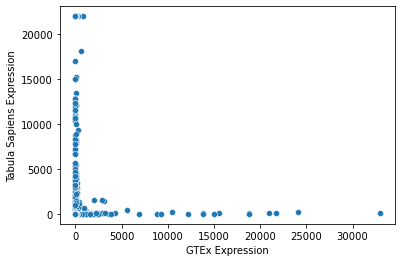

In [137]:
uberon_0002048 = uberon_subset('UBERON:0002048', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002048)

### 3.6.6 UBERON:0002106

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


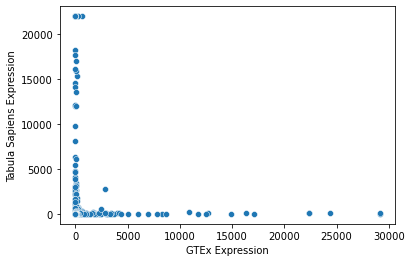

In [138]:
uberon_0002106 = uberon_subset('UBERON:0002106', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002106)

### 3.6.7 UBERON:0002107

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


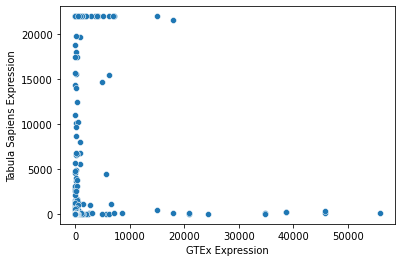

In [139]:
uberon_0002107 = uberon_subset('UBERON:0002107', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002107)

### 3.6.8 UBERON:0002190

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


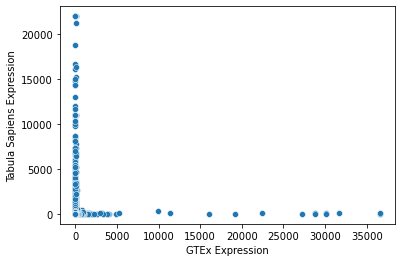

In [140]:
uberon_0002190 = uberon_subset('UBERON:0002190', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002190)

### 3.6.9 UBERON:0002367

/tmp/ipykernel_1438/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


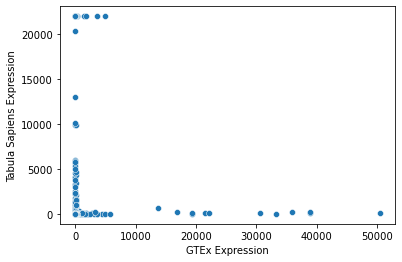

In [141]:
uberon_0002367 = uberon_subset('UBERON:0002367', merged_shared_uberon_id_datasets)

plot_gtex_tabula(uberon_0002367)

## 3.7 Plot GTEx vs Tabula Sapiens (highest proportion cell type in tissue)
### 3.7.1 Highest count cell type 

In [ ]:
#read in tabula data
tabula_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

In [28]:
#restructure tabula dataframe to count the number of cells in each cell type in each tissue
cell_type_counts = pd.DataFrame(tabula_adata.obs.groupby(['tissue_ontology_term_id', 'cell_type']).cell_type.count())
cell_type_counts = cell_type_counts.rename(columns = {'cell_type': 'cell_count'})

#filter for cell counts that are not zero
cell_type_counts = cell_type_counts[cell_type_counts.cell_count != 0]

#filter for the uberonid we are interested in
cell_type_counts = cell_type_counts[cell_type_counts.index.isin(shared_uberon_ids, level = 0)]

cell_type_counts

cell_count
tissue_ontology_term_id cell_type                                      
UBERON:0000178          hematopoietic stem cell                      70
                        common myeloid progenitor                     3
                        T cell                                       31
                        granulocyte                                   2
                        erythrocyte                               10484
...                                                                 ...
UBERON:0002367          myeloid cell                                365
                        neutrophil                                   16
                        mature NK T cell                            430
                        luminal cell of prostate epithelium        1092
                        basal cell of prostate epithelium          3298

[164 rows x 1 columns]

In [100]:
#maximum cell count for the cell type in each tissue
cell_type_counts.groupby('tissue_ontology_term_id').cell_count.max().dropna()

tissue_ontology_term_id
UBERON:0000178    10484.0
UBERON:0000947     2824.0
UBERON:0000995      154.0
UBERON:0001621     1906.0
UBERON:0002048    12160.0
UBERON:0002106     6460.0
UBERON:0002107     1558.0
UBERON:0002190     4567.0
UBERON:0002367     6848.0
Name: cell_count, dtype: float64

By comparing the maximum cell count with the cell type counts in each of the shared UBERONID tissues I found the highest proportion cell type to be as follows:
* UBERON:0000178 - erythrocyte (blood)
* UBERON:0000947 - fibroblast (aorta)
* UBERON:0000995 - fibroblast (uterus)
* UBERON:0001621 - fibroblast (coronary artery)
* UBERON:0002048 - macrophage (lung)
* UBERON:0002106 - memory B cell (spleen)
* UBERON:0002107 - hepatocyte (liver)
* UBERON:0002190 - fibroblast (adipose tissue)
* UBERON:0002367 - epithelial cell (prostate gland)

In [44]:
cell_type_counts.loc['UBERON:0002048'].sort_values(by = 'cell_count', ascending = False)

,cell_count
cell_type,
macrophage,12160
type II pneumocyte,9146
basal cell,2188
capillary endothelial cell,1534
classical monocyte,1487
club cell,1038
non-classical monocyte,1005
respiratory goblet cell,762
basophil,686


In [183]:
#set gene index for new dataframe
cell_type_comparison = pd.DataFrame(shared_uberon_id_tabula_sapiens.columns).set_index(0)

#create dictionary with UBERONID and highest proportion cell type pairs
dictionary = {'UBERON:0000178' : 'erythrocyte', 'UBERON:0000947' : 'fibroblast', 'UBERON:0000995' : 'fibroblast',
              'UBERON:0001621' : 'fibroblast', 'UBERON:0002048' : 'macrophage', 'UBERON:0002106' : 'memory b cell',
              'UBERON:0002107' : 'hepatocyte', 'UBERON:0002190' : 'fibroblast', 'UBERON:0002367' : 'epithelial cell'}

#filter the tabula sapiens dataframe using the dictionary
for i in range(len(dictionary)):
    filter_col = shared_uberon_id_tabula_sapiens.loc[list(dictionary.keys())[i], list(dictionary.values())[i]]
    cell_type_comparison.insert(0, list(dictionary.keys())[i],filter_col)

In [184]:
#transpose matrix to match GTEx
cell_type_comparison = cell_type_comparison.T

#concatenate dataframes and set levels as the dataset origin
merged_shared_uberon_id_celltype_datasets = pd.concat([shared_uberon_id_GTEx_expression, cell_type_comparison],
                                            keys = ['GTEx', 'Tabula_Sapiens'])
merged_shared_uberon_id_celltype_datasets

ENSG00000001561  ENSG00000002822  \
GTEx           UBERON:0001621             39.0              6.0   
               UBERON:0002107              5.0              3.0   
               UBERON:0002048             29.0              8.0   
               UBERON:0002367             12.0              8.0   
               UBERON:0002106             15.0             13.0   
               UBERON:0002190             23.0              8.0   
               UBERON:0000995              6.0             10.0   
               UBERON:0000947             34.0              7.0   
               UBERON:0000178              2.0              6.0   
Tabula_Sapiens UBERON:0002367              0.0              0.0   
               UBERON:0002190              0.0              0.0   
               UBERON:0002107              0.0              0.0   
               UBERON:0002106              0.0              0.0   
               UBERON:0002048              0.0              0.0   
               UBERON:0001621              0.0              0.0   
               UBERON:0000995              0.0              0.0   
               UBERON:0000947              0.0              0.0   
               UBERON:0000178              0.0              0.0   

                               ENSG00000004142  ENSG00000004766  \
GTEx           UBERON:0001621            118.0              8.0   
               UBERON:0002107            159.0              2.0   
               UBERON:0002048            100.0              8.0   
               UBERON:0002367            117.0              7.0   
               UBERON:0002106            104.0              9.0   
               UBERON:0002190            113.0              8.0   
               UBERON:0000995            117.0             10.0   
               UBERON:0000947            118.0              8.0   
               UBERON:0000178             36.0              1.0   
Tabula_Sapiens UBERON:0002367              0.0              0.0   
               UBERON:0002190              0.0              0.0   
               UBERON:0002107              0.0              0.0   
               UBERON:0002106              0.0              0.0   
               UBERON:0002048              0.0              0.0   
               UBERON:0001621              0.0              0.0   
               UBERON:0000995              0.0              0.0   
               UBERON:0000947              0.0              0.0   
               UBERON:0000178              0.0              0.0   

                               ENSG00000004809  ENSG00000004948  \
GTEx           UBERON:0001621              0.1              0.1   
               UBERON:0002107              0.0              0.0   
               UBERON:0002048              0.4              0.1   
               UBERON:0002367              0.1              0.0   
               UBERON:0002106              0.5              0.0   
               UBERON:0002190              0.2              0.1   
               UBERON:0000995              0.6              0.0   
               UBERON:0000947              0.1              0.1   
               UBERON:0000178              1.0              0.0   
Tabula_Sapiens UBERON:0002367              0.0              NaN   
               UBERON:0002190              0.0              NaN   
               UBERON:0002107              0.0              NaN   
               UBERON:0002106              0.0              NaN   
               UBERON:0002048              0.0              NaN   
               UBERON:0001621              0.0              NaN   
               UBERON:0000995              0.0              NaN   
               UBERON:0000947              0.0              NaN   
               UBERON:0000178              0.0              NaN   

                               ENSG00000004975  ENSG00000005073  \
GTEx           UBERON:0001621             22.0              0.0   
               UBERON:0002107              6.0              0.0   
        

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


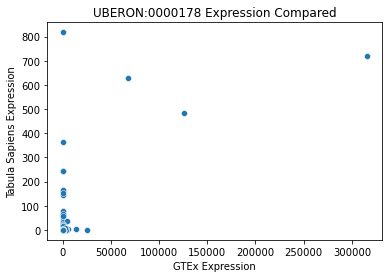

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


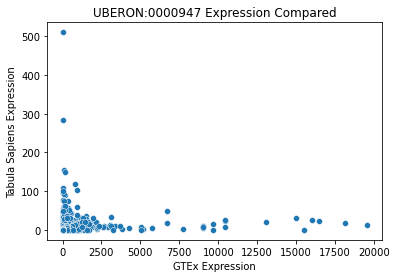

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


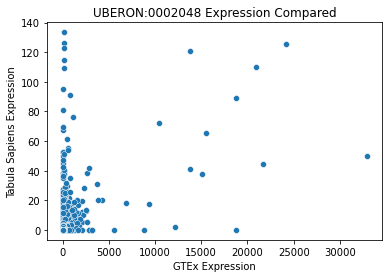

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


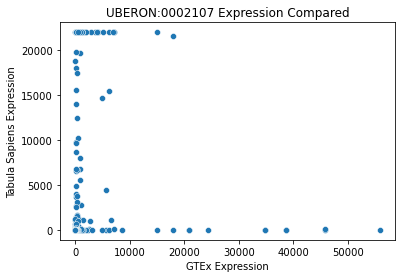

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


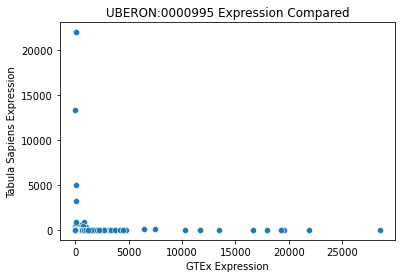

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


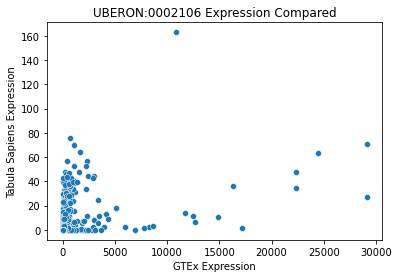

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


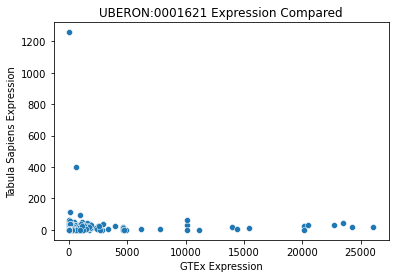

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


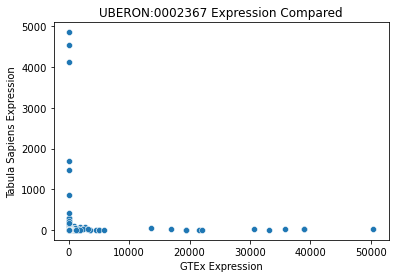

/tmp/ipykernel_1799/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


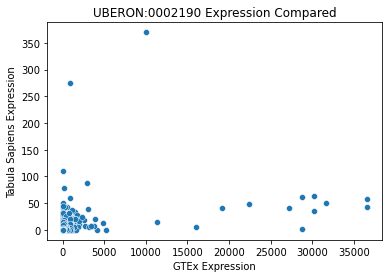

In [190]:
#plot GTEx expression against the expression in the highest proportion cell type of the tissue
for i in shared_uberon_ids:
    subset = uberon_subset(i, merged_shared_uberon_id_celltype_datasets)
    plt.title(f'{i} Expression Compared')
    plot_gtex_tabula(subset)

## 3.7.2 Alternative cell types

In [53]:
#set gene index for new dataframe
alt_cell_type_comparison = pd.DataFrame(shared_uberon_id_tabula_sapiens.columns).set_index(0)

#create dictionary with UBERONID and highest proportion cell type pairs
alt_dictionary = {'UBERON:0000947' : 'smooth muscle cell', 'UBERON:0000995' : 'epithelial cell of uterus',
              'UBERON:0001621' : 'smooth muscle cell', 'UBERON:0002048' : 'basal cell',
                  'UBERON:0002190' : 'endothelial cell', 'UBERON:0002367' : 'basal cell of prostate epithelium'}

#filter the tabula sapiens dataframe using the dictionary
for i in range(len(alt_dictionary)):
    filter_col = shared_uberon_id_tabula_sapiens.loc[list(alt_dictionary.keys())[i], list(alt_dictionary.values())[i]]
    alt_cell_type_comparison.insert(0, list(alt_dictionary.keys())[i],filter_col)

/tmp/ipykernel_1447/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


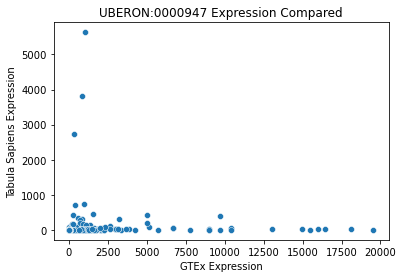

/tmp/ipykernel_1447/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


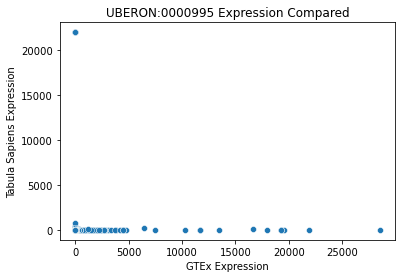

/tmp/ipykernel_1447/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


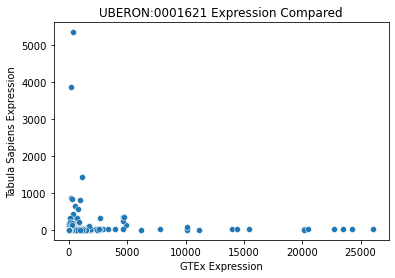

/tmp/ipykernel_1447/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


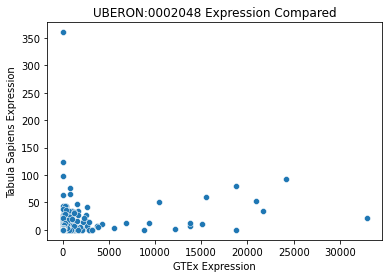

/tmp/ipykernel_1447/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


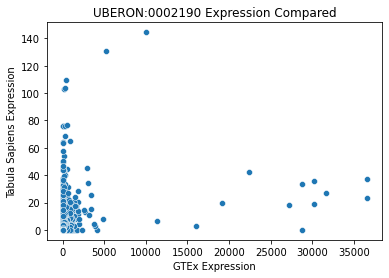

/tmp/ipykernel_1447/4160212502.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = 'GTEx', y = 'Tabula_Sapiens', data = scatter_df, palette = 'viridis')


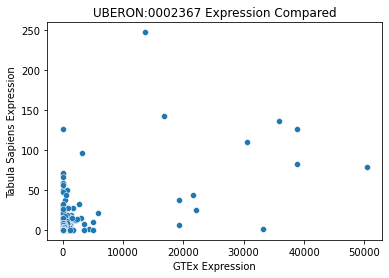

In [54]:
#transpose matrix to match GTEx
alt_cell_type_comparison = alt_cell_type_comparison.T

#concatenate dataframes and set levels as the dataset origin
alt_merged_shared_uberon_id_celltype_datasets = pd.concat([shared_uberon_id_GTEx_expression, alt_cell_type_comparison],
                                            keys = ['GTEx', 'Tabula_Sapiens'])

#plot GTEx expression against the expression in the highest proportion cell type of the tissue
for i in alt_dictionary.keys():
    subset = uberon_subset(i, alt_merged_shared_uberon_id_celltype_datasets)
    plt.title(f'{i} Expression Compared')
    plot_gtex_tabula(subset)

# ------------------------------------ Tabula Sapiens ---------------------------------------------------

# 4. Gene expression distributions across cell types

In [ ]:
#read in data from saved pickle
tabula_sapiens = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')

In [52]:
tabula_sapiens

ENSG00000227232  ENSG00000268903  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000241860  ENSG00000279457  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000228463  ENSG00000237094  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                                   0.0              0.0   
               endothelial cell                         0.0              0.0   
               mast cell                                0.0              0.0   
               myeloid cell                             0.0              0.0   
               pancreatic acinar cell                   0.0              0.0   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              0.0              0.0   
               plasmacytoid dendritic cell              0.0              0.0   
               smooth muscle cell                       0.0              0.0   
               t cell                                   0.0              0.0   
               vein endothelial cell                    0.0              0.0   

                                            ENSG00000225972  ENSG00000225630  \
uberon_id      cell_type                                                       
UBERON:0000016 b cell                              0.000000         0.101790   
               endothelial cell                    0.000000         0.000000   
               mast cell                           0.027070         1.606588   
               myeloid cell                        0.000000         0.000000   
               pancreatic acinar cell              0.000000         0.000000   
...                                                     ...              ...   
UBERON:0018707 plasma cell                         0.000000         0.000000   
               plasmacytoid dendritic cell         0.000000         0.000000   
               smooth muscle cell                  2.210239         0.000000   
               t cell                    

In [99]:
def gene_expression_dist(gene):
    gene_df = pd.DataFrame(tabula_sapiens[gene])
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), gene_df.plot.hist()

## 4.1 Housekeeping genes
### 4.1.1 TATA-binding protein

(                                                      ENSG00000112592
 uberon_id      cell_type                                             
 UBERON:0001811 corneal keratocyte                           85.244965
 UBERON:0000029 plasmacytoid dendritic cell                  18.323747
 UBERON:0001542 mature conventional dendritic cell           17.560957
                cd141-positive myeloid dendritic cell         8.017619
 UBERON:0001296 epithelial cell                               0.965091
 UBERON:0001817 retinal bipolar neuron                        0.650983
 UBERON:0001773 radial glial cell                             0.617669
 UBERON:0000995 ciliated epithelial cell                      0.459593
 UBERON:0001295 myometrial cell                               0.421759
 UBERON:0001817 conjunctival epithelial cell                  0.008174,
 <AxesSubplot:ylabel='Frequency'>)

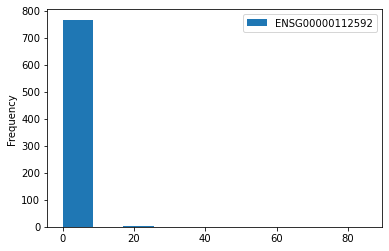

In [100]:
gene_expression_dist('ENSG00000112592')

### 4.1.2 Glyceraldehyde 3-phosphate dehydrogenase

(                                 ENSG00000111640
 uberon_id      cell_type                        
 UBERON:0002382 fast muscle cell       255.684875
 UBERON:0008612 fast muscle cell       183.204704
 UBERON:0002385 fast muscle cell       180.763229
 UBERON:0002382 slow muscle cell       143.423676
 UBERON:0002385 slow muscle cell       100.548531
 ...                                          ...
 UBERON:0002190 leucocyte                0.334035
 UBERON:0000029 erythrocyte              0.196621
 UBERON:0002107 neutrophil               0.131529
 UBERON:0008612 mast cell                0.099537
 UBERON:0000059 goblet cell              0.095047
 
 [732 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

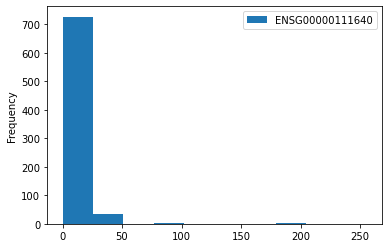

In [101]:
gene_expression_dist('ENSG00000111640')

### 4.1.3 Ubiquitin C

(                                           ENSG00000150991
 uberon_id      cell_type                                  
 UBERON:0002378 slow muscle cell                 161.947510
                fast muscle cell                  93.181667
 UBERON:0000970 corneal epithelial cell           71.685738
 UBERON:0000995 epithelial cell                   67.578125
 UBERON:0002108 intestinal crypt stem cell        65.723389
 ...                                                    ...
 UBERON:0001817 corneal keratocyte                 0.293267
                b cell                             0.278574
                t cell                             0.174173
                plasma cell                        0.100177
 UBERON:0000970 erythroid lineage cell             0.005090
 
 [744 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

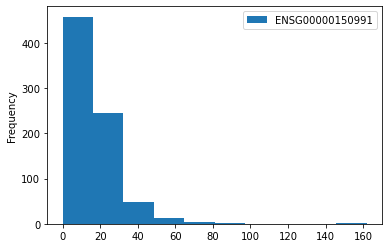

In [102]:
gene_expression_dist('ENSG00000150991')

### 4.1.4 RNA polymerase II A

(                                                              ENSG00000181222
 uberon_id      cell_type                                                     
 UBERON:0002190 mast cell                                            20.340637
 UBERON:0000059 intestinal crypt stem cell of large intestine        14.849761
 UBERON:0000964 monocyte                                             10.282755
 UBERON:0002378 endothelial cell of lymphatic vessel                 10.280470
 UBERON:0000995 ciliated epithelial cell                             10.181124
 ...                                                                       ...
 UBERON:0002385 cd4-positive, alpha-beta t cell                       0.037900
 UBERON:0010032 basal cell                                            0.030567
 UBERON:0000995 fibroblast                                            0.022366
 UBERON:0001868 endothelial cell                                      0.012243
 UBERON:0001817 conjunctival epithelial cell        

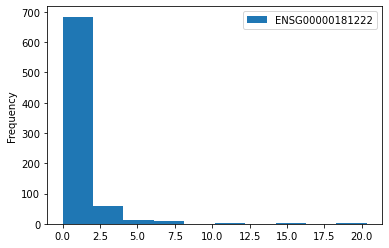

In [109]:
gene_expression_dist('ENSG00000181222')

### 4.1.5 Actin beta A

(                                                   ENSG00000075624
 uberon_id      cell_type                                          
 UBERON:0000995 pericyte cell                            176.757210
 UBERON:0001817 monocyte                                 148.683914
 UBERON:0001542 mature conventional dendritic cell       115.679115
 UBERON:0000178 platelet                                 106.248489
 UBERON:0002106 platelet                                  92.753807
 ...                                                            ...
 UBERON:0000016 pancreatic acinar cell                     0.192315
 UBERON:0001542 erythrocyte                                0.059368
 UBERON:0008612 slow muscle cell                           0.045236
 UBERON:0002382 mesothelial cell                           0.005560
 UBERON:0001013 leucocyte                                  0.001822
 
 [753 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

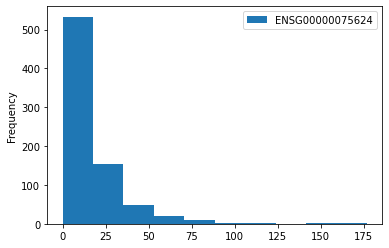

In [110]:
gene_expression_dist('ENSG00000075624')

## 4.2 Highly specifically expressed genes
### 4.2.1 Insulin (pancreatic beta cells)

(                                      ENSG00000254647
 uberon_id      cell_type                             
 UBERON:0000016 pancreatic beta cell      22025.464844
 UBERON:0000017 pancreatic alpha cell     22025.464844
                pancreatic beta cell      22025.464844
                pancreatic delta cell     22025.464844
                pancreatic pp cell        22025.464844
 UBERON:0000016 t cell                    13016.688354
 UBERON:0000017 fibroblast                 1506.253906
                b cell                      190.635605
                plasma cell                   7.536572,
 <AxesSubplot:ylabel='Frequency'>)

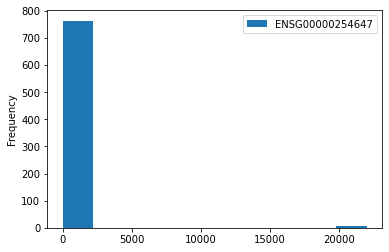

In [103]:
gene_expression_dist('ENSG00000254647')

### 4.2.2 Surfactant protein C (alveolar type II epithelial lung cells)

(                                   ENSG00000168484
 uberon_id      cell_type                          
 UBERON:0002048 type ii pneumocyte      1603.281738
                neutrophil                 3.458284
                plasma cell                0.488018,
 <AxesSubplot:ylabel='Frequency'>)

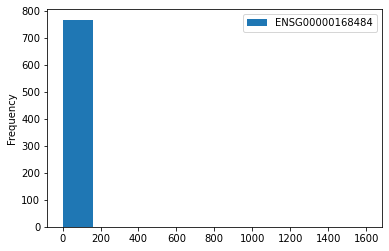

In [104]:
gene_expression_dist('ENSG00000168484')

### 4.2.3 Amylase 2B (pancreatic exocrine glandular cells)

(                                       ENSG00000243480
 uberon_id      cell_type                              
 UBERON:0000016 pancreatic acinar cell     22025.464844
 UBERON:0000017 pancreatic acinar cell      4227.371338
 UBERON:0001817 erythroid lineage cell         0.068147,
 <AxesSubplot:ylabel='Frequency'>)

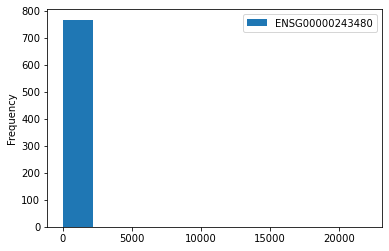

In [107]:
gene_expression_dist('ENSG00000243480')

# 5. Gene distribution across cell types in single tissue (lung)

In [113]:
lung = tabula_sapiens.loc['UBERON:0002048']
lung

,ENSG00000227232,ENSG00000268903,ENSG00000241860,ENSG00000279457,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,0.0,0.0,0.0,0.0,0.0,0.0,1.183307,0.400979,0.168980,0.641111,...,11.630584,0.0,0.000000,0.0,11.635146,7.044630,0.000000,43.097694,0.000000,0.917278
alveolar fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,20.089952,0.0,0.000000,0.0,7.516644,0.000000,0.000000,41.347870,0.000000,0.000000
b cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,45.461964,0.0,0.000000,0.0,9.980330,0.000000,0.000000,53.718769,0.000000,0.000000
basal cell,0.0,0.0,0.0,0.0,0.0,0.0,4.748219,0.000000,0.000000,0.000000,...,22.288073,0.0,0.000000,0.0,12.511540,0.000000,0.000000,59.612795,0.000000,0.000000
basophil,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,75.807106,0.0,0.000000,0.0,17.793551,0.000000,0.000000,73.837502,0.000000,0.000000
bronchial smooth muscle cell,0.0,0.0,0.0,0.0,0.0,0.0,0.947153,0.000000,0.000000,0.000000,...,24.119442,0.0,0.000000,0.0,10.053258,0.000000,0.000000,47.871376,0.000000,0.000000
bronchial vessel endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,17.817963,0.0,2.158052,0.0,6.873465,0.000000,4.038792,19.667601,0.000000,2.800178
capillary aerocyte,0.0,0.0,0.0,0.0,0.0,0.0,1.304875,0.000000,0.000000,0.000000,...,9.166449,0.0,0.000000,0.0,6.062207,0.000000,0.000000,19.548586,0.000000,0.000000
capillary endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,1.186989,0.000000,0.000000,0.000000,...,9.973212,0.0,0.000000,0.0,6.389586,0.000000,0.000000,21.672670,0.000000,0.000000


In [114]:
def gene_expression_dist(gene):
    gene_df = pd.DataFrame(lung[gene])
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), gene_df.plot.hist()

## 5.1 Housekeeping genes
### 5.1.1 TBP

(Empty DataFrame
 Columns: [ENSG00000112592]
 Index: [],
 <AxesSubplot:ylabel='Frequency'>)

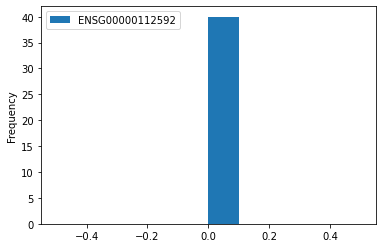

In [116]:
gene_expression_dist('ENSG00000112592')

### 5.1.2 GADPH

(                                        ENSG00000111640
 cell_type                                              
 bronchial vessel endothelial cell             19.245228
 classical monocyte                            17.277014
 smooth muscle cell                            15.927636
 pulmonary ionocyte                            14.246191
 lung microvascular endothelial cell           13.454399
 dendritic cell                                12.618114
 capillary aerocyte                            11.906199
 intermediate monocyte                         11.061234
 adventitial cell                              10.203913
 basal cell                                     9.855150
 bronchial smooth muscle cell                   9.289935
 vein endothelial cell                          8.968944
 mesothelial cell                               8.735196
 cd8-positive, alpha-beta t cell                8.491459
 fibroblast                                     8.229611
 non-classical monocyte        

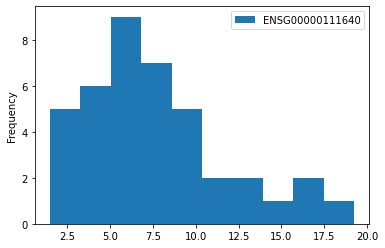

In [115]:
gene_expression_dist('ENSG00000111640')

### 5.1.3 UBC

(                                        ENSG00000150991
 cell_type                                              
 adventitial cell                              44.382084
 type i pneumocyte                             31.123575
 fibroblast                                    29.677852
 alveolar fibroblast                           26.708118
 capillary aerocyte                            24.388277
 endothelial cell of artery                    24.306667
 bronchial smooth muscle cell                  22.669346
 vascular associated smooth muscle cell        20.128073
 basal cell                                    19.578646
 pulmonary ionocyte                            19.393513
 capillary endothelial cell                    19.170170
 vein endothelial cell                         18.541168
 mesothelial cell                              18.516920
 type ii pneumocyte                            18.325041
 pericyte cell                                 17.912912
 myofibroblast cell            

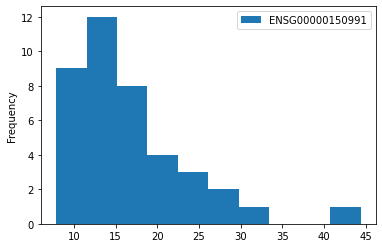

In [117]:
gene_expression_dist('ENSG00000150991')

## 5.2 Highly specific genes
### 5.2.1 INS

(Empty DataFrame
 Columns: [ENSG00000254647]
 Index: [],
 <AxesSubplot:ylabel='Frequency'>)

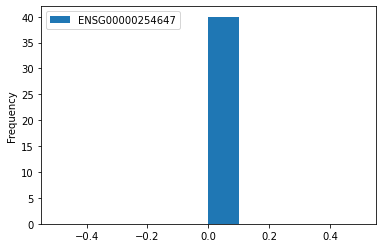

In [118]:
gene_expression_dist('ENSG00000254647')

### 5.2.2 SFTPC

(                    ENSG00000168484
 cell_type                          
 type ii pneumocyte      1603.281738
 neutrophil                 3.458284
 plasma cell                0.488018,
 <AxesSubplot:ylabel='Frequency'>)

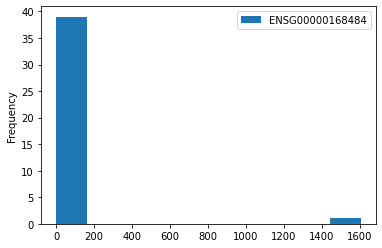

In [119]:
gene_expression_dist('ENSG00000168484')

### 5.2.3 AMY2B

(Empty DataFrame
 Columns: [ENSG00000243480]
 Index: [],
 <AxesSubplot:ylabel='Frequency'>)

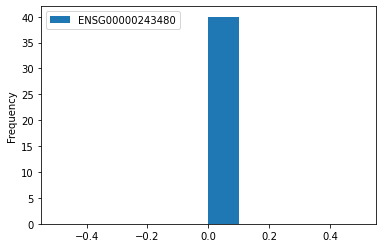

In [120]:
gene_expression_dist('ENSG00000243480')

# 6. Distribution of genes across all cells in a single tissue (lung)

In [2]:
#read in whole Tabula Sapiens dataset
all_cells = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

In [3]:
#filter out lung cells
lung = all_cells[all_cells.obs.tissue_ontology_term_id == 'UBERON:0002048']

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [4]:
#convert sparse matrix to dense matrix and exponentiate expression values
lung_counts = pd.DataFrame.sparse.from_spmatrix(lung.X)
lung_counts = np.expm1(lung_counts)

In [5]:
#add gene names to the columns
gene_names = lung.var.index.values
lung_counts = lung_counts.set_axis(gene_names, axis = 1)

#add cell type
cell_type = lung.obs['cell_ontology_class'].values
lung_counts.insert(0, 'cell_type', cell_type)

lung_counts = lung_counts.drop(lung_counts.columns[(lung_counts == 0).all()], axis = 1)

In [6]:
lung_counts

,cell_type,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000240361,ENSG00000238009,ENSG00000239945,ENSG00000233750,ENSG00000268903,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,29.522684,2.162206,0.000000,0.0,4.916226,1.774017,0.000000,38.670734,0.000000,0.501866
1,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,54.292229,0.000000,7.440341,0.0,10.121305,1.045985,1.703557,77.216110,16.125153,16.106915
2,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,57.446617,0.000000,0.000000,0.0,6.876759,0.000000,0.000000,91.006187,742.667969,0.000000
3,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,35.597107,0.000000,4.850770,0.0,10.596470,2.675121,2.093883,55.183472,5.199052,3.902307
4,type ii pneumocyte,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,42.046162,0.000000,0.000000,0.0,5.038349,1.063540,0.000000,50.367680,0.000000,0.834576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35677,macrophage,0.0,0.192152,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,9.547097,0.000000,0.000000,0.0,1.227417,7.775701,2.027940,27.854317,0.000000,9.888508
35678,plasma cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,3.653382,0.000000,0.000000,0.0,4.010193,3.241796,0.131419,11.836517,0.000000,4.659379
35679,lung microvascular endothelial cell,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,34.462471,0.000000,0.000000,0.0,64.982445,3121.358154,977.833069,19.161039,0.000000,0.000000
35680,neutrophil,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,1.666218,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
def gene_expression_dist(gene):
    gene_df = pd.DataFrame(lung_counts[gene])
    return gene_df[gene_df[gene] != 0].sort_values(by = gene, ascending = False), gene_df.plot.hist(bins = 200)

## 6.1 Housekeeping genes
### 6.1.1 TBP

(       ENSG00000112592
 17538     22025.464844
 17543     22025.464844
 17391     22025.464844
 7081      10871.542969
 17000      9724.833984
 ...                ...
 17301         0.018035
 17260         0.015536
 34785         0.011285
 35475         0.010427
 34875         0.009874
 
 [4135 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

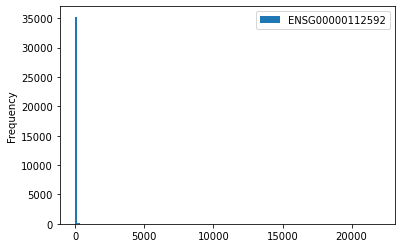

In [40]:
gene_expression_dist('ENSG00000112592')

### 6.1.2 GADPH

(       ENSG00000111640
 17257       139.732819
 17077       104.785324
 17161        93.782806
 34838        68.739792
 17059        64.421562
 ...                ...
 17226         0.019493
 17285         0.014508
 17013         0.011145
 17052         0.009790
 16980         0.004210
 
 [33791 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

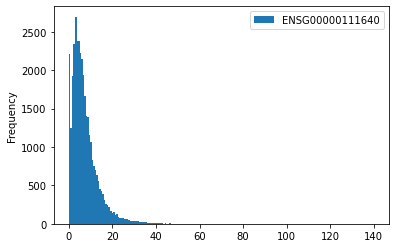

In [41]:
gene_expression_dist('ENSG00000111640')

### 6.1.3 UBC

(       ENSG00000150991
 9831        451.778137
 17039       303.227356
 7359        286.216095
 9965        276.679016
 12790       268.299133
 ...                ...
 16990         0.096152
 17061         0.039150
 35599         0.037328
 17063         0.026555
 17443         0.025698
 
 [35134 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

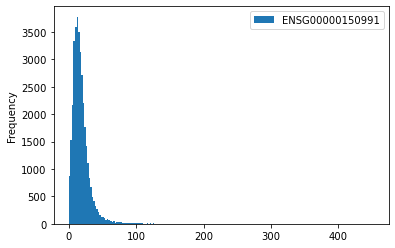

In [42]:
gene_expression_dist('ENSG00000150991')

## 6.2 Highly specific genes
### 6.2.1 INS

(       ENSG00000254647
 8754      22025.464844
 10425     20341.980469
 10052      2126.052002
 11991        41.587708
 9957         27.267170
 11633        26.226860
 8566         22.681904
 13295        18.712683
 16348        18.352549
 9543          7.217002,
 <AxesSubplot:ylabel='Frequency'>)

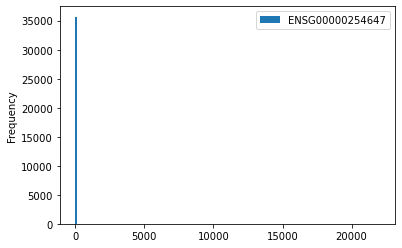

In [43]:
gene_expression_dist('ENSG00000254647')

### 6.2.2 SFTPC

(       ENSG00000168484
 35095      9214.166016
 16961      9130.375000
 16901      8732.451172
 25605      8345.250977
 35087      7580.894531
 ...                ...
 10970         0.421243
 7104          0.386240
 4406          0.319181
 9230          0.210344
 11654         0.208874
 
 [9488 rows x 1 columns],
 <AxesSubplot:ylabel='Frequency'>)

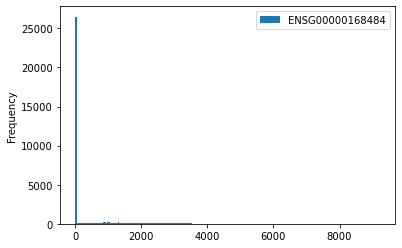

In [44]:
gene_expression_dist('ENSG00000168484')

### 6.2.3 AMY2B

(       ENSG00000243480
 13189        13.366562
 17344         0.146436,
 <AxesSubplot:ylabel='Frequency'>)

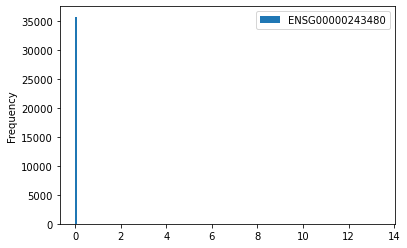

In [45]:
gene_expression_dist('ENSG00000243480')

# 7. Comparison of lung expressions (Tabula Sapien cell types vs GTEx)

In [43]:
#read in whole median expression counts Tabula Sapiens dataset
all_cells = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')

## 7.1 Unique cell types in the lung

In [57]:
#filter out lung cells from grouped expressions from all cells
lung = all_cells.loc['UBERON:0002048']
lung

,ENSG00000227232,ENSG00000268903,ENSG00000241860,ENSG00000279457,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,0.0,0.0,0.0,0.0,0.0,0.0,1.183307,0.400979,0.168980,0.641111,...,11.630584,0.0,0.000000,0.0,11.635146,7.044630,0.000000,43.097694,0.000000,0.917278
alveolar fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,20.089952,0.0,0.000000,0.0,7.516644,0.000000,0.000000,41.347870,0.000000,0.000000
b cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,45.461964,0.0,0.000000,0.0,9.980330,0.000000,0.000000,53.718769,0.000000,0.000000
basal cell,0.0,0.0,0.0,0.0,0.0,0.0,4.748219,0.000000,0.000000,0.000000,...,22.288073,0.0,0.000000,0.0,12.511540,0.000000,0.000000,59.612795,0.000000,0.000000
basophil,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,75.807106,0.0,0.000000,0.0,17.793551,0.000000,0.000000,73.837502,0.000000,0.000000
bronchial smooth muscle cell,0.0,0.0,0.0,0.0,0.0,0.0,0.947153,0.000000,0.000000,0.000000,...,24.119442,0.0,0.000000,0.0,10.053258,0.000000,0.000000,47.871376,0.000000,0.000000
bronchial vessel endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,17.817963,0.0,2.158052,0.0,6.873465,0.000000,4.038792,19.667601,0.000000,2.800178
capillary aerocyte,0.0,0.0,0.0,0.0,0.0,0.0,1.304875,0.000000,0.000000,0.000000,...,9.166449,0.0,0.000000,0.0,6.062207,0.000000,0.000000,19.548586,0.000000,0.000000
capillary endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,1.186989,0.000000,0.000000,0.000000,...,9.973212,0.0,0.000000,0.0,6.389586,0.000000,0.000000,21.672670,0.000000,0.000000


This shows there are 40 unique cell types in the liver whose expression can be plotted against the bulk expression. I next want to understand how many cells were captured for each cell type; this was done using a previous version accounting for all cells.

In [37]:
#this can no longer be run but was obtained by creating a dataframe from the total cells expression counts and filtering for lung
lung_counts.groupby('cell_type').ENSG00000223972.count().sort_values(ascending = False)

/tmp/ipykernel_1870/1985686269.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lung_counts.groupby('cell_type').ENSG00000223972.count().sort_values(ascending = False)


cell_type
macrophage                                12160
type ii pneumocyte                         9146
basal cell                                 2188
classical monocyte                         1487
club cell                                  1038
non-classical monocyte                     1005
capillary endothelial cell                  965
respiratory goblet cell                     754
basophil                                    686
lung ciliated cell                          602
capillary aerocyte                          569
cd8-positive, alpha-beta t cell             552
cd4-positive, alpha-beta t cell             543
vein endothelial cell                       508
lung microvascular endothelial cell         485
adventitial cell                            373
alveolar fibroblast                         324
dendritic cell                              316
intermediate monocyte                       252
pericyte cell                               213
type i pneumocyte             

# 7.2 Plot cell expression vs GTEx expression for each cell type in lung

### 7.2.1 Load GTEx data

In [49]:
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

### 7.2.2 Filter for lung GTEx data

In [55]:
lung_GTEx = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0002048'])
lung_GTEx = lung_GTEx.rename(columns = {'UBERON:0002048': 'GTEx_lung'})
lung_GTEx

,GTEx_lung
geneProductId,
ENSG00000001561,29.0
ENSG00000002822,8.0
ENSG00000004142,100.0
ENSG00000004766,8.0
ENSG00000004809,0.4
...,...
ENSG00000281676,2.0
ENSG00000281741,0.5
ENSG00000281809,1.0


### 7.2.3 Define function to merge GTEx lung expression data with Tabula Sapiens lung cell type expression data

In [102]:
def plot_GTEx_lung_cell_type(cell_type):
    
    #filter tabula lung expression df for the cell type of interest
    cell_type_df = pd.DataFrame(lung.loc[cell_type])
    
    expression_df = pd.concat([lung_GTEx, cell_type_df], axis = 1).fillna(0)
    
    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx_lung', y = cell_type, data = expression_df)
    plt.xlabel('GTEx Expression')
    plt.ylabel(f'Tabula Sapiens {cell_type} Expression')
    
    return plt.show()

### 7.2.4 Plot scatterplots for Tabula lung cell type expression vs GTEx lung (median expression counts)

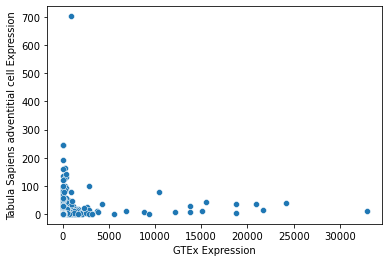

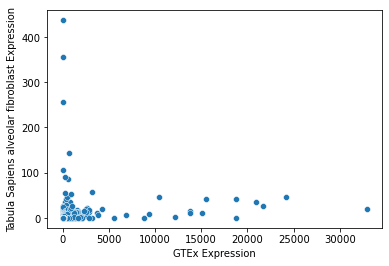

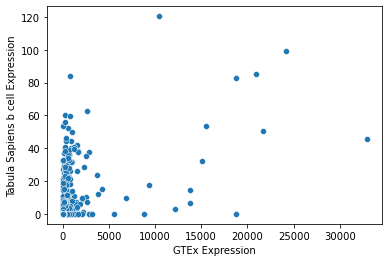

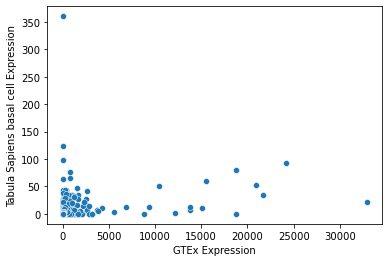

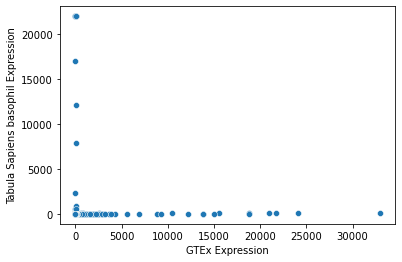

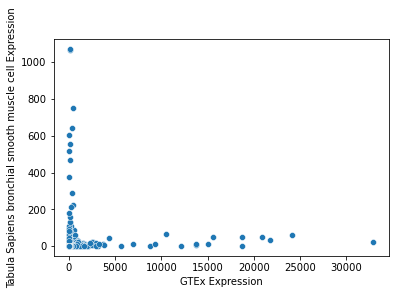

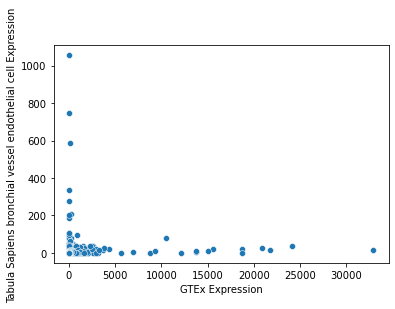

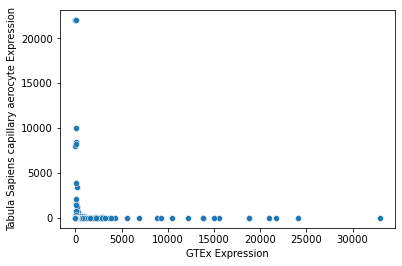

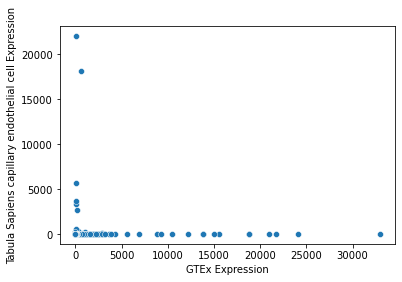

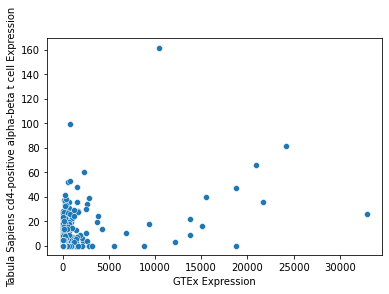

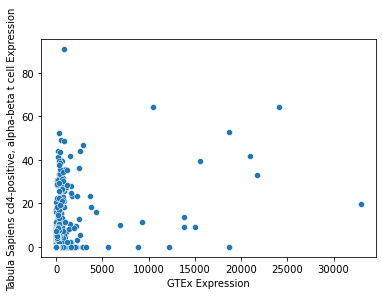

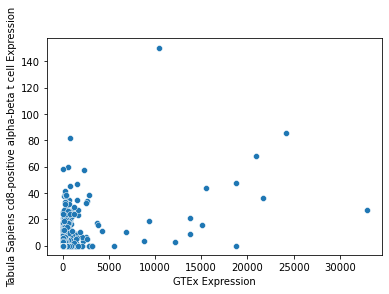

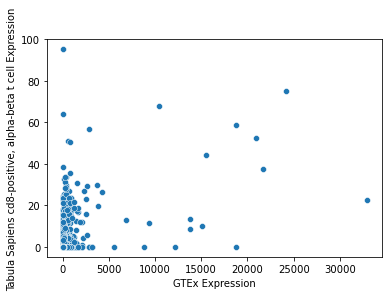

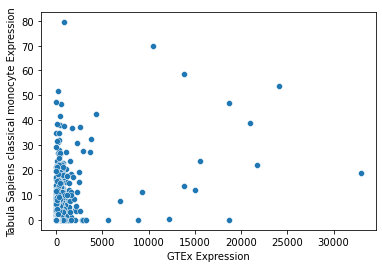

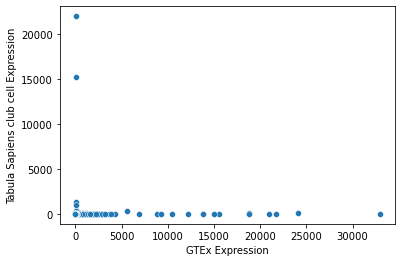

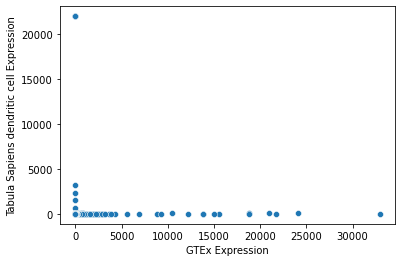

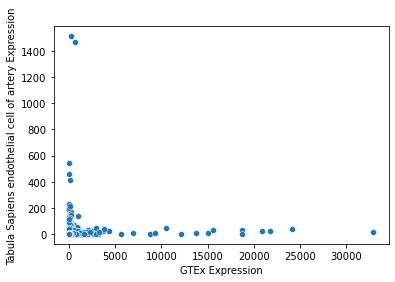

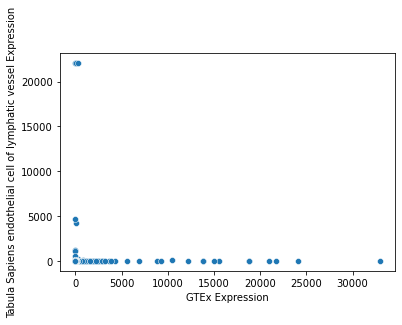

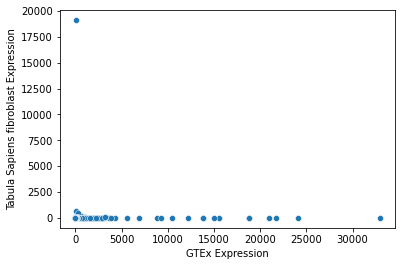

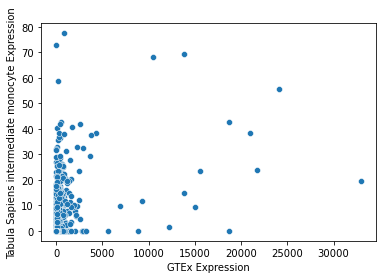

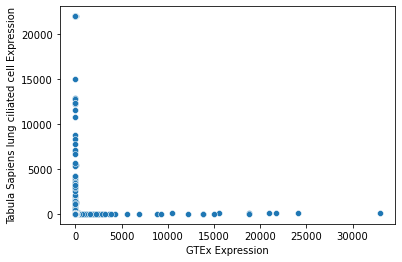

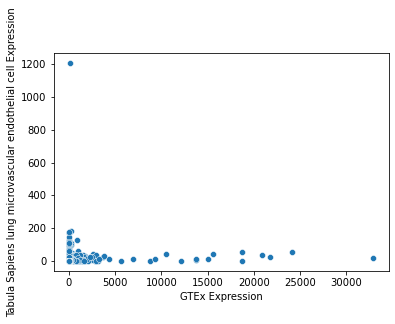

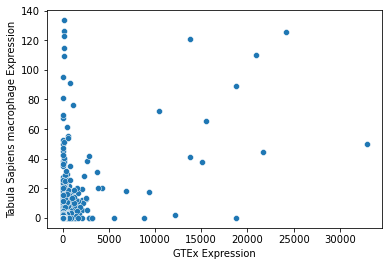

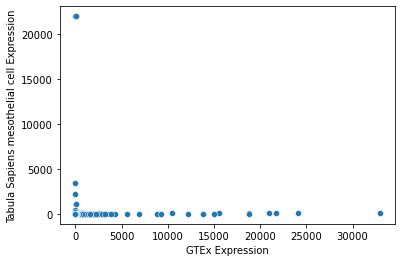

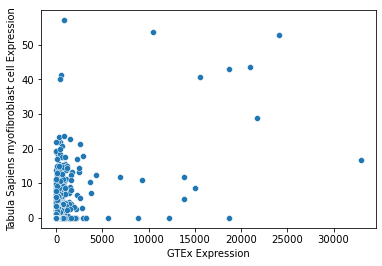

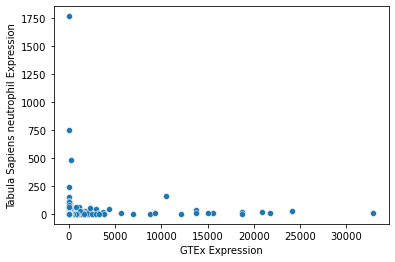

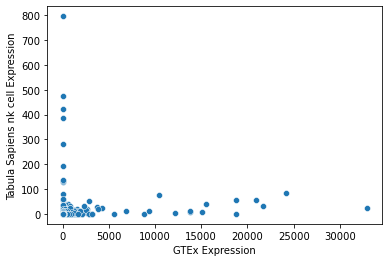

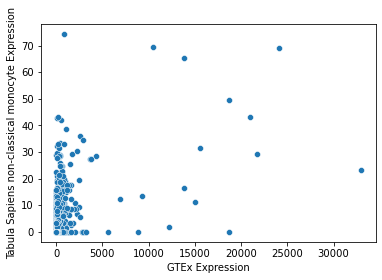

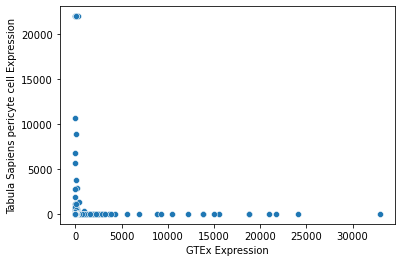

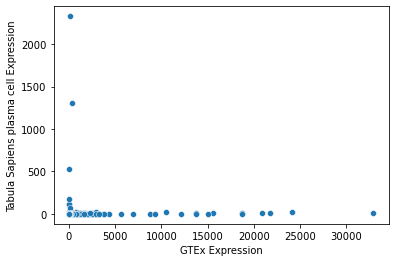

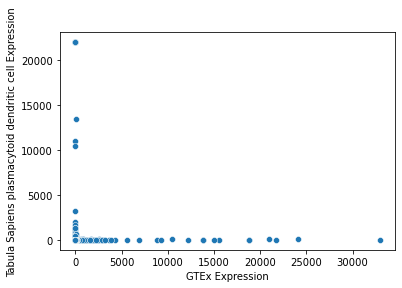

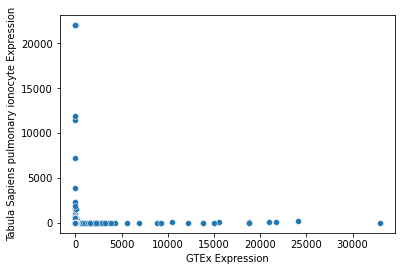

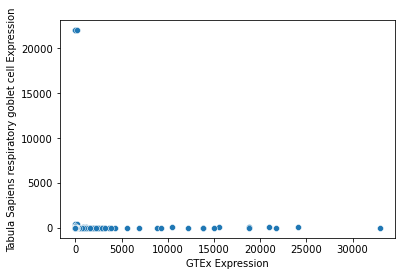

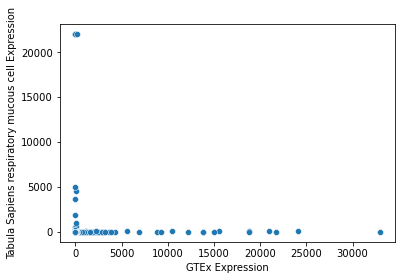

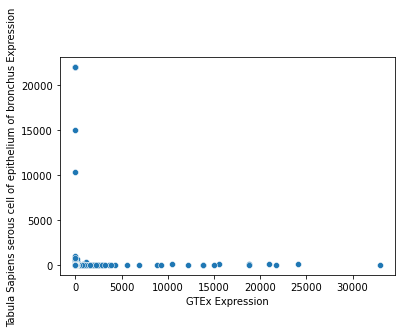

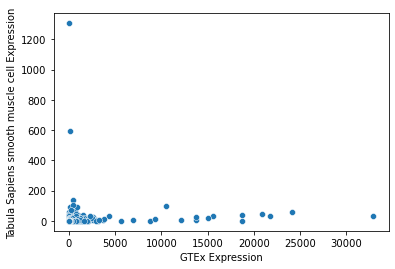

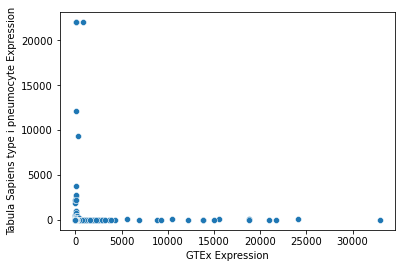

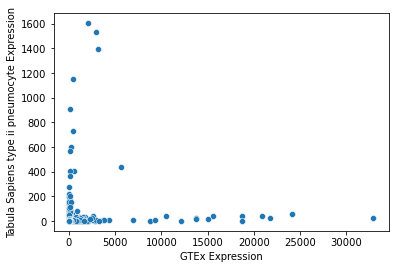

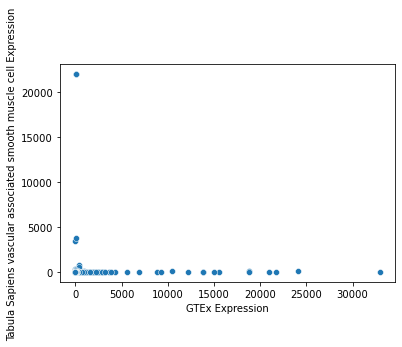

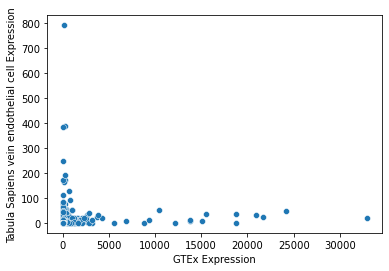

In [103]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in lung.index:
    plot_GTEx_lung_cell_type(f'{i}')

For most of the cell types the median expression across the two datasets are an order of magnitude apart with GTEx TPM expression ranging in the thousands and tabula sapiens often ranging in the hundreds however there are some genes which show a much higher expression in Tabula Sapiens than others. Nevertheless, there doesn't appear to be much correlation between the GTEx and Tabula Sapiens expression values.

# 8. Comparing gene expression in pancreas across GTEx and Tabula Sapiens
## 8.1 Pre-process pancreas data
### 8.1.1 Tabula Sapiens pancreas

In [2]:
#load adata for Tabula Sapiens
all_cells_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

#processing exocrine and endocrine pancreas count data
exo_pancreas = pd.DataFrame.sparse.from_spmatrix(exo_pancreas_adata.X)
exo_pancreas = np.expm1(exo_pancreas)
exo_pancreas = exo_pancreas.sparse.to_dense()
exo_pancreas = exo_pancreas.set_axis(exo_pancreas_adata.var.index.values, axis = 1)
exo_pancreas.insert(0, 'cell_type', exo_pancreas_adata.obs['cell_ontology_class'].values)


endo_pancreas = pd.DataFrame.sparse.from_spmatrix(endo_pancreas_adata.X)
endo_pancreas = np.expm1(endo_pancreas)
endo_pancreas = endo_pancreas.sparse.to_dense()
endo_pancreas = endo_pancreas.set_axis(endo_pancreas_adata.var.index.values, axis = 1)
endo_pancreas.insert(0, 'cell_type', endo_pancreas_adata.obs['cell_ontology_class'].values)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [3]:
#merge the endocrine and exocrine pancreas data together
pancreas = pd.concat([exo_pancreas, endo_pancreas], ignore_index = True)

In [42]:
pancreas.to_pickle('total_pancreas_counts.pkl', compression = 'gzip')

In [37]:
pancreas_median = pancreas.groupby('cell_type').median()

In [39]:
pancreas_median

,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000284332,ENSG00000237613,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
b cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.308130,0.0,0.0,0.0,4.780235,0.003785,0.000000,35.284365,0.0,0.000000
endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.317610,0.0,0.0,0.0,7.285459,0.753106,0.000000,38.533302,0.0,0.000000
fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,70.948250,0.0,0.0,0.0,29.251474,8.613832,0.000000,135.960556,0.0,0.000000
mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.676102,0.0,0.0,0.0,13.550352,2.213558,0.000000,60.747269,0.0,0.591658
myeloid cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.901643,0.0,0.0,0.0,11.489692,0.495923,0.000000,32.555159,0.0,0.000000
nk cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.311382,0.0,0.0,0.0,17.200932,2.353448,0.000000,63.761822,0.0,0.000000
pancreatic acinar cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.349838,0.0,0.0,0.0,5.106372,0.580418,0.000000,44.419600,0.0,0.000000
pancreatic alpha cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.754948,0.0,0.0,0.0,12.260982,3.094373,0.000000,52.760540,0.0,0.000000
pancreatic beta cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.293533,0.0,0.0,0.0,10.712899,2.861094,0.000000,87.007309,0.0,0.000000


In [40]:
pancreas_median.to_pickle('pancreas_median_counts.pkl', compression = 'gzip')

In [2]:
#read in whole pancreas median data for each cell type
pancreas = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')

### 8.1.2 GTEx pancreas

In [3]:
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

In [4]:
GTEx_pancreas = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0001264'])
GTEx_pancreas = GTEx_pancreas.rename(columns = {'UBERON:0001264': 'GTEx_pancreas'})

## 8.2 Plot gene expression across each pancreatic cell type to GTEx expression

In [5]:
def plot_GTEx_pancreas_cell_type(cell_type):
    
    #filter tabula pancreas expression df for the cell type of interest
    cell_type_df = pd.DataFrame(pancreas.loc[cell_type])
    
    expression_df = pd.concat([GTEx_pancreas, cell_type_df], axis = 1).fillna(0)
    
    #create scatterplot to visualise
    sns.scatterplot(x = 'GTEx_pancreas', y = cell_type, data = expression_df)
    plt.xlabel('GTEx Expression')
    plt.ylabel(f'Tabula Sapiens {cell_type} Expression')
    plt.title(f'Comparing gene expression between GTEx and Tabula Sapiens {cell_type}')
    
    return plt.show()

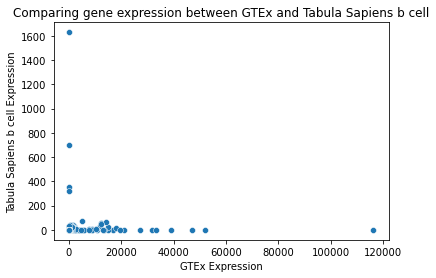

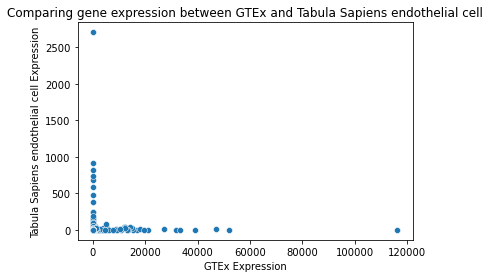

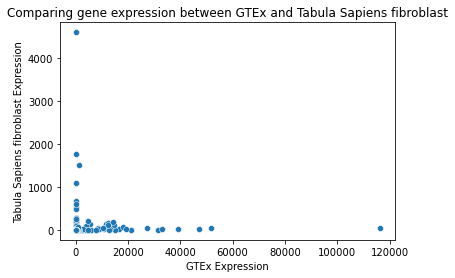

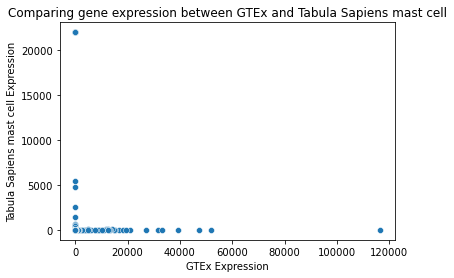

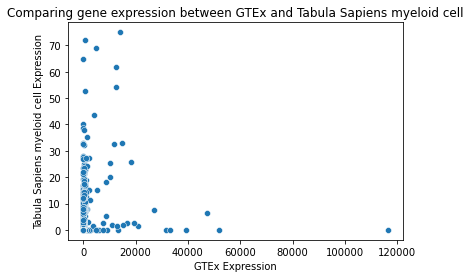

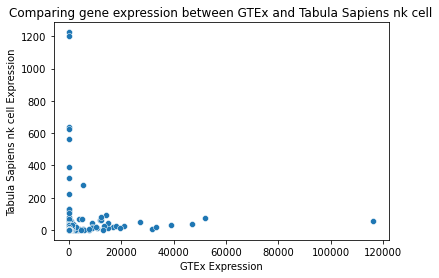

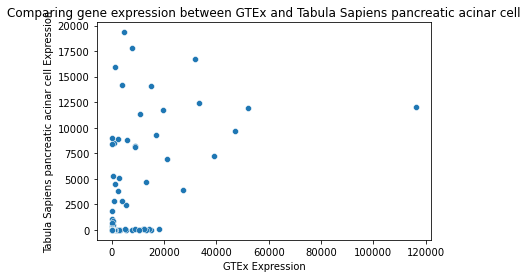

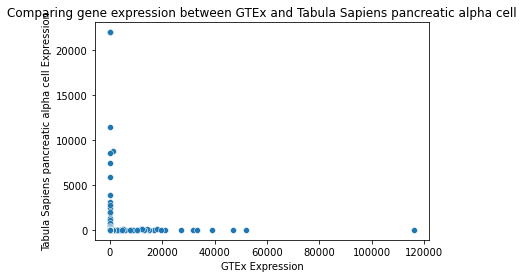

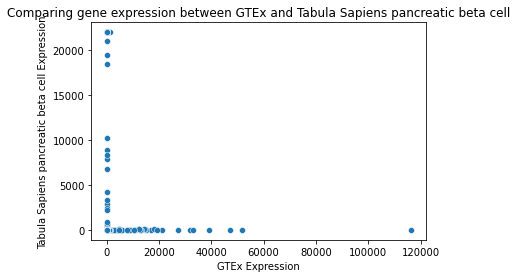

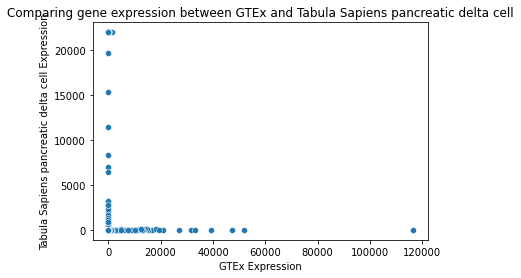

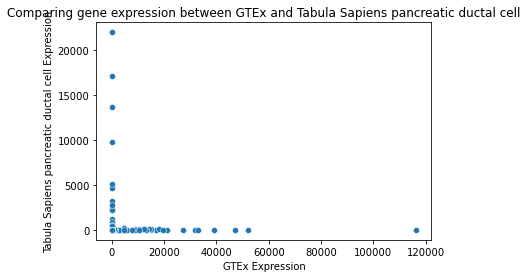

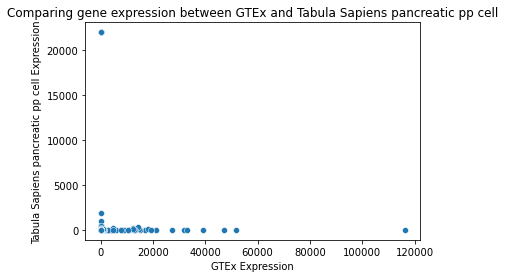

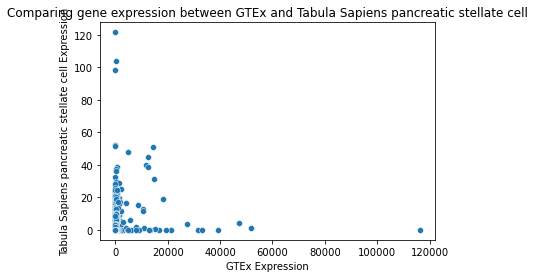

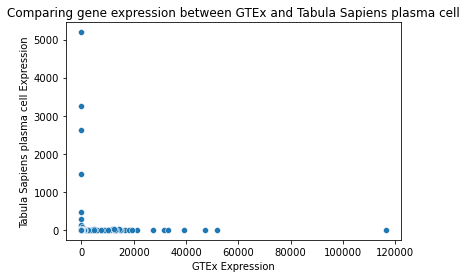

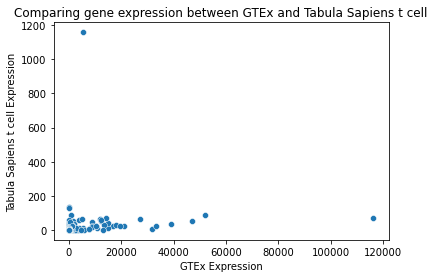

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in pancreas.index:
    plot_GTEx_pancreas_cell_type(f'{i}')

This shows that the median expressions across multiple genes in Tabula Sapiens and GTEx are often not on the same magnitude scale of expression.

## 8.3 Plot insulin expression across individual Tabula cells vs GTEx median

In [7]:
total_cell_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

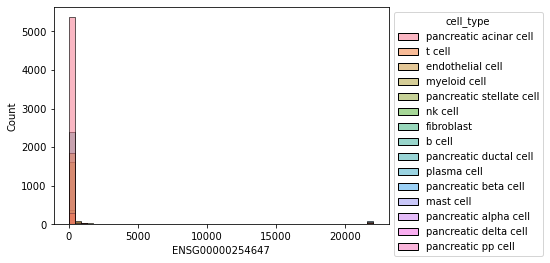

In [15]:
ax = sns.histplot(data = total_cell_pancreas, x = 'ENSG00000254647', bins = 50, hue ='cell_type')
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

**Remove zero counts to view expression values better**

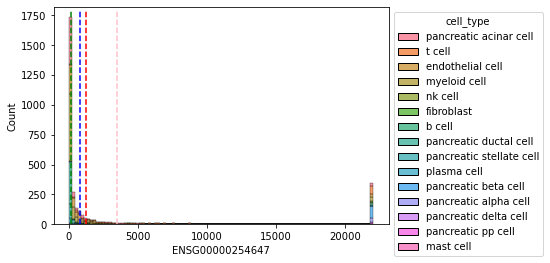

In [45]:
#plotting histogram of total cell NON-ZERO expression counts for insulin gene in pancreas
ax = sns.histplot(data = total_cell_pancreas[total_cell_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', bins = 100, 
                  hue ='cell_type', multiple = 'stack')

#move legend outside of plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

#draw line where GTEx median insulin expression lies
ax.axvline(x = GTEx_pancreas.loc['ENSG00000254647'].values.tolist(), ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')

#mean of total pancreas cell counts for insulin (including zero-expression)
ax.axvline(x = total_cell_pancreas['ENSG00000254647'].mean(), ymin = 0, ymax = 0.98, color = 'blue', linestyle = 'dashed')

#median of total pancreas cell counts for insulin (EXcluding zero-expression)
ax.axvline(x = total_cell_pancreas[total_cell_pancreas['ENSG00000254647'] > 0]['ENSG00000254647'].median(), 
           ymin = 0, ymax = 0.98, color = 'green', linestyle = 'dashed')

Could taking the median of the non-zero expression of cell types be a better metric and if all zero then take the zero expression???????

# 9. Virtual lung (single-cell weighted median expression)
## 9.1 Read in data

In [61]:
#read in whole median expression counts Tabula Sapiens dataset
all_cells = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')

#filter out lung
lung = all_cells.loc['UBERON:0002048']

In [62]:
#read in GTEx expressions
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

#filter out lung cells and rename column
lung_GTEx = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0002048'])
lung_GTEx = lung_GTEx.rename(columns = {'UBERON:0002048': 'GTEx_lung'})

## 9.2 Identify shared genes between Tabula Sapiens lung and GTEx lung data

In [4]:
print(f'Tabula lung has {len(lung.columns)} genes and GTEx lung has {len(lung_GTEx.index)} genes')

Tabula lung has 24166 genes and GTEx lung has 46711 genes


In [63]:
shared_genes = set(lung_GTEx.index) & set(lung.columns)
print(f' The number of shared genes between Tabula lung and GTEx lung is {len(shared_genes)}')

 The number of shared genes between Tabula lung and GTEx lung is 22975


## 9.3 Filter datasets for these genes

In [64]:
lung = lung[lung.columns.intersection(shared_genes)]
lung_GTEx = lung_GTEx.filter(items = shared_genes, axis = 0)

## 9.4 Calculate weighted median expression of genes for each cell type
### 9.4.1 Identify proportions of each cell type

In [65]:
lung_counts = pd.read_pickle('lung_counts.pkl', compression = 'gzip')

In [8]:
print(f'There are {len(lung_counts)} total lung cells')

There are 35682 total lung cells


In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

lung_cell_type = pd.DataFrame(lung_counts.groupby('cell_type').ENSG00000223972.count())
lung_cell_type = lung_cell_type.rename(columns = {'ENSG00000223972': 'count'})

In [67]:
lung_cell_type['proportion'] = lung_cell_type['count'] / len(lung_counts)

### 9.4.2 Multiply each cell type row by the proportion

In [68]:
#list of cell type proportions
proportion_list = lung_cell_type['proportion'].to_list()

#extract gene columns for multiplication
gene_columns = lung.columns.difference(['cell_type'])

#multiply each column in the row by the corresponding cell type proportion
lung[gene_columns] = lung[gene_columns].mul(proportion_list, axis = 0)

lung

,ENSG00000227232,ENSG00000268903,ENSG00000241860,ENSG00000279457,ENSG00000228463,ENSG00000237094,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,...,ENSG00000212907,ENSG00000198886,ENSG00000210176,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.012370,0.004192,0.001766,0.006702,...,0.067896,0.121580,0.0,0.0,0.121627,0.073641,0.000000,0.450520,0.000000,0.009589
alveolar fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.013455,0.182421,0.0,0.0,0.068253,0.000000,0.000000,0.375447,0.000000,0.000000
b cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.006843,0.110846,0.0,0.0,0.024334,0.000000,0.000000,0.130977,0.000000,0.000000
basal cell,0.0,0.0,0.0,0.0,0.0,0.0,0.291158,0.000000,0.000000,0.000000,...,0.053221,1.366692,0.0,0.0,0.767201,0.000000,0.000000,3.655423,0.000000,0.000000
basophil,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.093815,1.457420,0.0,0.0,0.342088,0.000000,0.000000,1.419554,0.000000,0.000000
bronchial smooth muscle cell,0.0,0.0,0.0,0.0,0.0,0.0,0.002150,0.000000,0.000000,0.000000,...,0.005029,0.054752,0.0,0.0,0.022821,0.000000,0.000000,0.108671,0.000000,0.000000
bronchial vessel endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.003106,0.023470,0.0,0.0,0.009054,0.000000,0.005320,0.025906,0.000000,0.003688
capillary aerocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.020808,0.000000,0.000000,0.000000,...,0.000000,0.146172,0.0,0.0,0.096670,0.000000,0.000000,0.311730,0.000000,0.000000
capillary endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.032101,0.000000,0.000000,0.000000,...,0.000000,0.269720,0.0,0.0,0.172803,0.000000,0.000000,0.586125,0.000000,0.000000


In [30]:
lung.to_pickle('weighted_median_cell_type_lung.pkl', compression = 'gzip')

## 9.5 Calculate sum of weighted expression for each gene across all cell types

In [ ]:
lung = pd.read_pickle('weighted_median_cell_type_lung.pkl', compression = 'gzip')

In [69]:
sum_weighted_gene_expression = pd.DataFrame(lung.columns)

sum_expression = []
for i in lung.columns:
    sum_expression.append(lung[i].sum())
    
sum_weighted_gene_expression['sum_expression'] = sum_expression
sum_weighted_gene_expression = sum_weighted_gene_expression.rename(columns = {0: 'geneProductId'})
sum_weighted_gene_expression = sum_weighted_gene_expression.set_index('geneProductId')

## 9.6 Compare Tabula sum expression to GTEx

In [70]:
expression_df = pd.concat([sum_weighted_gene_expression, lung_GTEx], axis = 1)
expression_df

,sum_expression,GTEx_lung
geneProductId,,
ENSG00000227232,0.000000,3.0
ENSG00000268903,0.000000,27.0
ENSG00000241860,0.000000,3.0
ENSG00000279457,0.000000,6.0
ENSG00000228463,0.000000,1.0
...,...,...
ENSG00000198695,0.207572,8809.0
ENSG00000210194,0.005711,394.0
ENSG00000198727,48.591060,15558.0


## 9.7 Plot Tabula data vs GTEx data

In [71]:
def tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    plt.show()
    
def zoomed_tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 50)
    plt.show()

<Figure size 432x288 with 0 Axes>

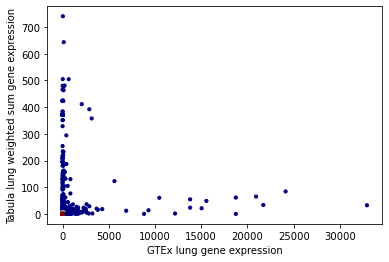

In [91]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

<Figure size 432x288 with 0 Axes>

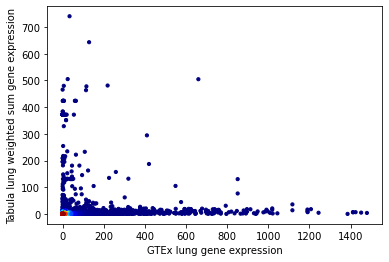

<Figure size 432x288 with 0 Axes>

In [84]:
tabula_vs_GTEx_expression(expression_df[expression_df.GTEx_lung < 1500].GTEx_lung, 
                          expression_df[expression_df.GTEx_lung < 1500].sum_expression)

plt.savefig('tabula_vs_GTEx_lung_expression.png')

<Figure size 432x288 with 0 Axes>

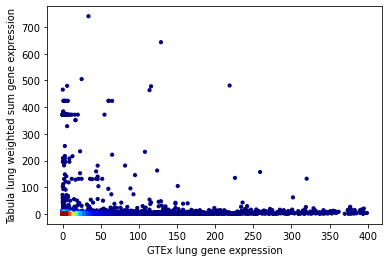

In [82]:
tabula_vs_GTEx_expression(expression_df[expression_df.GTEx_lung < 400].GTEx_lung, 
                          expression_df[expression_df.GTEx_lung < 400].sum_expression)

<Figure size 432x288 with 0 Axes>

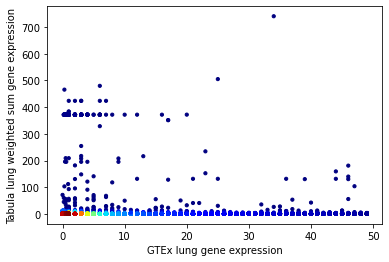

In [83]:
tabula_vs_GTEx_expression(expression_df[expression_df.GTEx_lung < 50].GTEx_lung, 
                          expression_df[expression_df.GTEx_lung < 50].sum_expression)

<Figure size 432x288 with 0 Axes>

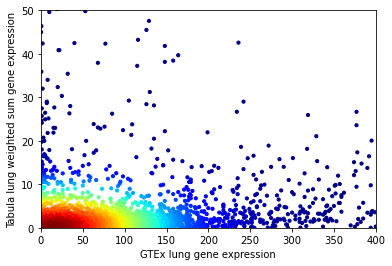

In [92]:
#zoom in on GTEx axis between 0-400 counts and zoom in on Tabula axis between 0-50
zoomed_tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

## 9.8 Genes with huge discrepancies between Tabula and GTEx

In [87]:
expression_df['difference'] = expression_df['sum_expression'] - expression_df['GTEx_lung']
expression_df.sort_values(['difference'], ascending = False)

,sum_expression,GTEx_lung,difference
geneProductId,,,
ENSG00000108576,740.203872,34.0,706.203872
ENSG00000164265,642.977633,129.0,513.977633
ENSG00000043591,504.851500,25.0,479.851500
ENSG00000125999,479.619589,6.0,473.619589
ENSG00000197446,465.422356,0.3,465.122356
...,...,...,...
ENSG00000228253,0.045188,18739.0,-18738.954812
ENSG00000198804,64.978049,20929.0,-20864.021951
ENSG00000198899,33.419304,21716.0,-21682.580696


ENSG00000228253, ENSG00000198804, ENSG00000198899, ENSG00000198712 and ENSG00000198886 are mitochondrially encoded genes suggesting that some mitochondrial contamination has remained after filtering: it has a medium expression in Tabula but is very high in GTEx suggesting that GTEx did not have a stringent enough mitochondrial filtering protocol. These mitochondrial genes however appear to make up a proportion of the genes that have a lower Tabula expression and a higher GTEx expression which correspond to the outliers on the GTEx axis. None of the top 10 genes with differences (positive or negative) are pseudogenes however. 

**For insight into mitochondrial-encoded genes look at part 9. on Expression Data Exploration notebook**

# 9.9 Plotting expression of mitochondrial-genes across Tabula virtual lung and GTEx lung
### 9.9.1 Access MT-encoded genes

In [102]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()

#subset out genes that contain MT- in their gene name
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Gene name'].str.contains('MT-')]

#remove the last two genes that are not mitochondrial-encoded genes
mt_genes = mt_genes[0:-2]

#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

### 9.9.2 Filter expression df with MT-encoded genes

In [82]:
#filter comparison expression df by the mitochondrial-encoded genes
expression_df.filter(items = mt_encoded_genes, axis = 0)

,sum_expression,GTEx_lung
geneProductId,,
ENSG00000210049,0.000000,86.0
ENSG00000211459,23.226540,2274.0
ENSG00000210077,0.000138,2.0
ENSG00000210082,60.391982,10462.0
ENSG00000209082,0.000000,126.0
ENSG00000198888,21.044314,15038.0
ENSG00000210107,0.000000,5.0
ENSG00000210112,0.000641,4.0
ENSG00000198763,23.363386,13796.0


Here, only 33 of the mitochondrial-genes are shared between Tabula Sapiens and GTEx after processing suggesting that one or both of the studies had 4 mitocondrial-encoded genes removed during processing since they had zero median expression across all cells within the lung tissue.

### 9.9.3 Plot the MT-encoded genes across Tabula Sapiens virtual lung and GTEx lung

<Figure size 432x288 with 0 Axes>

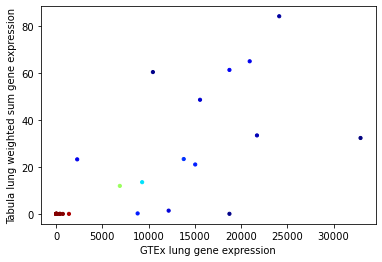

In [92]:
#scatterplot of mitochondrial-encoded genes across Tabula Sapiens virtual lung and GTEx lung
tabula_vs_GTEx_expression(expression_df.filter(items = mt_encoded_genes, axis = 0).GTEx_lung, 
                          expression_df.filter(items = mt_encoded_genes, axis = 0).sum_expression)

**Compare to the plot of all shared genes between Tabula Sapiens and GTEx lung**

<Figure size 432x288 with 0 Axes>

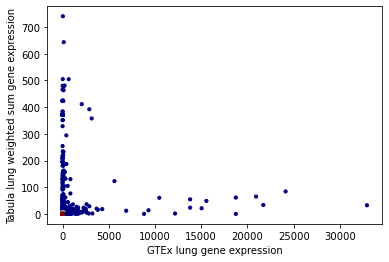

In [91]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

I can see that the mitochondrial genes account for most of the GTEx outliers seen when Tabula expression is low on the bottom of the plot. If I remove the mitochondrial genes how does this affect the scatterplot.

### 9.9.4 Plot expressions without MT-encoded genes

In [108]:
#filter out genes not in the expression df
MT_genes = [i for i in mt_encoded_genes if i not in ('ENSG00000210100', 'ENSG00000210151', 
                                                                    'ENSG00000210174', 'ENSG00000210184')]

<Figure size 432x288 with 0 Axes>

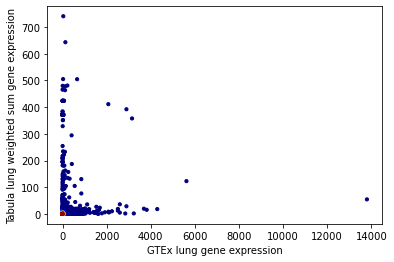

In [116]:
tabula_vs_GTEx_expression(expression_df.drop(index = MT_genes).GTEx_lung, 
                         expression_df.drop(index = MT_genes).sum_expression)

<Figure size 432x288 with 0 Axes>

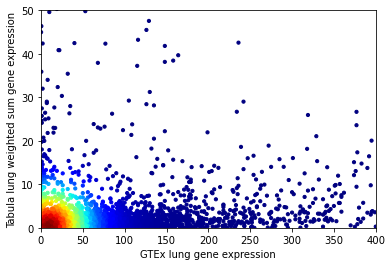

In [118]:
zoomed_tabula_vs_GTEx_expression(expression_df.drop(index = MT_genes).GTEx_lung, 
                         expression_df.drop(index = MT_genes).sum_expression)

I see that removing the mitochondrial-encoded genes removes a lot of the data points that had a lower Tabula virtual lung expression and a high GTEx expression.

# 10. Virtual lung using average_metric counts
## 10.1 Read in data

In [5]:
#read in average_metric tabula data
tabula = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

#filter out lung
lung = tabula.loc['UBERON:0002048']

In [7]:
#read in GTEx expressions
uberon_id_GTEx_expression = pd.read_pickle('uberon_id_GTEx_expression.pkl', compression = 'gzip')

#filter out lung cells and rename column
lung_GTEx = pd.DataFrame(uberon_id_GTEx_expression.loc['UBERON:0002048'])
lung_GTEx = lung_GTEx.rename(columns = {'UBERON:0002048': 'GTEx_lung'})

## 10.2 Identify shared genes between Tabula Sapiens lung and GTEx lung data

In [10]:
shared_genes = set(lung_GTEx.index) & set(lung.columns)
print(f' The number of shared genes between Tabula lung and GTEx lung is {len(shared_genes)}')

 The number of shared genes between Tabula lung and GTEx lung is 44779


## 10.3 Filter datasets for these genes

In [11]:
lung = lung[lung.columns.intersection(shared_genes)]
lung_GTEx = lung_GTEx.filter(items = shared_genes, axis = 0)

## 10.4 Calculate weighted median expressions for genes for each cell type
### 10.4.1 Identify proportions of each cell type

In [12]:
lung_counts = pd.read_pickle('lung_counts.pkl', compression = 'gzip')

lung_cell_type = pd.DataFrame(lung_counts.groupby('cell_type').ENSG00000223972.count())
lung_cell_type = lung_cell_type.rename(columns = {'ENSG00000223972': 'count'})

lung_cell_type['proportion'] = lung_cell_type['count'] / len(lung_counts)

/tmp/ipykernel_1826/3400341045.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lung_cell_type = pd.DataFrame(lung_counts.groupby('cell_type').ENSG00000223972.count())


### 10.4.2 Multiply each cell type row by the proportion

In [13]:
#list of cell type proportions
proportion_list = lung_cell_type['proportion'].to_list()

#extract gene columns for multiplication
gene_columns = lung.columns.difference(['cell_type'])

#multiply each column in the row by the corresponding cell type proportion
lung[gene_columns] = lung[gene_columns].mul(proportion_list, axis = 0)

lung

/tmp/ipykernel_1826/2710723792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung[gene_columns] = lung[gene_columns].mul(proportion_list, axis = 0)


,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,ENSG00000239906,ENSG00000241860,...,ENSG00000212907,ENSG00000198886,ENSG00000210176,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
cell_type,,,,,,,,,,,,,,,,,,,,,
adventitial cell,NaN,0.024094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.072107,0.121712,NaN,NaN,0.122604,0.097314,0.063053,0.450520,NaN,0.108125
alveolar fibroblast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.030855,0.185915,NaN,NaN,0.078370,0.043085,NaN,0.380380,NaN,0.089679
b cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.008734,0.110846,NaN,NaN,0.025163,0.012151,NaN,0.131411,NaN,NaN
basal cell,NaN,0.174622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.135489,1.367466,2.077273,NaN,0.776856,0.199564,0.176406,3.655423,2.439025,0.388942
basophil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.112982,1.459193,NaN,NaN,0.344114,0.089515,NaN,1.424657,NaN,NaN
bronchial smooth muscle cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009595,0.054752,NaN,NaN,0.023142,0.010725,NaN,0.108671,NaN,NaN
bronchial vessel endothelial cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003578,0.023470,0.012286,NaN,0.010200,0.003784,0.020069,0.025906,NaN,0.009831
capillary aerocyte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.051479,0.149935,NaN,NaN,0.107636,0.081577,NaN,0.312607,8.529628,NaN
capillary endothelial cell,NaN,0.288247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.086951,0.273137,NaN,NaN,0.193049,0.154045,0.092796,0.592254,23.966876,0.329211


In [14]:
lung.to_pickle('weighted_average_metric_lung.pkl', compression = 'gzip')

## 10.5 Sum of weighted expression for each gene across all cell types

In [ ]:
lung = pd.read_pickle('weighted_average_metric_lung.pkl', compression = 'gzip')

In [15]:
sum_weighted_gene_expression = pd.DataFrame(lung.columns)

sum_expression = []
for i in lung.columns:
    sum_expression.append(lung[i].sum())
    
sum_weighted_gene_expression['sum_expression'] = sum_expression
sum_weighted_gene_expression = sum_weighted_gene_expression.rename(columns = {0: 'geneProductId'})
sum_weighted_gene_expression = sum_weighted_gene_expression.set_index('geneProductId')

## 10.6 Compare Tabula sum expression to GTEx

In [16]:
expression_df = pd.concat([sum_weighted_gene_expression, lung_GTEx], axis = 1)
expression_df

,sum_expression,GTEx_lung
ENSG00000223972,0.000000,0.0
ENSG00000227232,5.249213,3.0
ENSG00000278267,0.000000,1.0
ENSG00000243485,0.000000,0.0
ENSG00000238009,4047.103335,0.8
...,...,...
ENSG00000198695,2.744686,8809.0
ENSG00000210194,3.738437,394.0
ENSG00000198727,48.672436,15558.0
ENSG00000210195,101.428190,2.0


## 10.7 Plot Tabula data vs GTEx data

In [19]:
def tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    plt.show()
    
def zoomed_tabula_vs_GTEx_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=10)
    ax.set_xlabel('GTEx lung gene expression')
    ax.set_ylabel('Tabula lung weighted sum gene expression')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 50)
    plt.show()

<Figure size 432x288 with 0 Axes>

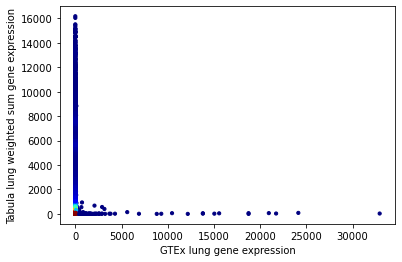

In [20]:
tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)

<Figure size 432x288 with 0 Axes>

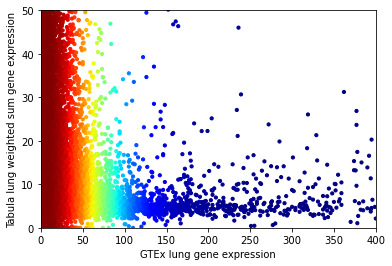

In [21]:
zoomed_tabula_vs_GTEx_expression(expression_df.GTEx_lung, expression_df.sum_expression)